In [1]:
import pandas as pd
import numpy as np
df1 = pd.read_csv("data/HDB_Prices/HDB/resale-flat-prices-based-on-approval-date-1990-1999.csv")
df2 = pd.read_csv("data/HDB_Prices/HDB/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
df3 = pd.read_csv("data/HDB_Prices/HDB/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
df4 = pd.read_csv("data/HDB_Prices/HDB/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")
df5 = pd.read_csv("data/HDB_Prices/HDB/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

In [2]:
df = pd.concat([df1,df2,df3,df4,df5])

In [3]:
df['year'] = df['month'].apply(lambda x: int(x[0:4]))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 826581 entries, 0 to 80373
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                826581 non-null  object 
 1   town                 826581 non-null  object 
 2   flat_type            826581 non-null  object 
 3   block                826581 non-null  object 
 4   street_name          826581 non-null  object 
 5   storey_range         826581 non-null  object 
 6   floor_area_sqm       826581 non-null  float64
 7   flat_model           826581 non-null  object 
 8   lease_commence_date  826581 non-null  int64  
 9   resale_price         826581 non-null  float64
 10  remaining_lease      117527 non-null  object 
 11  year                 826581 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 82.0+ MB


In [5]:
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,year
count,826581.000000,826581.000000,8.265810e+05,826581.000000
mean,95.557909,1987.149345,2.935490e+05,2004.234957
std,26.057093,9.451743,1.487536e+05,7.926336
min,28.000000,1966.000000,5.000000e+03,1990.000000
25%,73.000000,1980.000000,1.810000e+05,1998.000000
50%,93.000000,1986.000000,2.750000e+05,2003.000000
75%,114.000000,1994.000000,3.830000e+05,2010.000000
max,307.000000,2019.000000,1.258000e+06,2020.000000


### check unique values

In [6]:
for i in df.columns:
    print ('unique values for', i)
    print ('value counts', df[i].value_counts())
    print(df[i].unique())

unique values for month
value counts month
1999-03    6468
1999-06    5862
1998-10    5709
1999-04    5698
1999-05    5671
           ... 
1991-02     816
1990-10     810
1990-05     778
2020-04     424
2020-05     363
Name: count, Length: 369, dtype: int64
['1990-01' '1990-02' '1990-03' '1990-04' '1990-05' '1990-06' '1990-07'
 '1990-08' '1990-09' '1990-10' '1990-11' '1990-12' '1991-01' '1991-02'
 '1991-03' '1991-04' '1991-05' '1991-06' '1991-07' '1991-08' '1991-09'
 '1991-10' '1991-11' '1991-12' '1992-01' '1992-02' '1992-03' '1992-04'
 '1992-05' '1992-06' '1992-07' '1992-08' '1992-09' '1992-10' '1992-11'
 '1992-12' '1993-01' '1993-02' '1993-03' '1993-04' '1993-05' '1993-06'
 '1993-07' '1993-08' '1993-09' '1993-10' '1993-11' '1993-12' '1994-01'
 '1994-02' '1994-03' '1994-04' '1994-05' '1994-06' '1994-07' '1994-08'
 '1994-09' '1994-10' '1994-11' '1994-12' '1995-01' '1995-02' '1995-03'
 '1995-04' '1995-05' '1995-06' '1995-07' '1995-08' '1995-09' '1995-10'
 '1995-11' '1995-12' '1996-01' '

In [7]:
import re
def calculate_remaining_lease(x):
    if pd.isna(x):
        return np.nan

    s = str(x).strip()   

    # "66 years 03 months"
    m = re.search(r'(\d+)\s*years?\s*(\d+)\s*months?', s, flags=re.IGNORECASE)
    if m:
        years = int(m.group(1))
        months = int(m.group(2))
        return years + months / 12

    # "66 years"
    m = re.search(r'(\d+)\s*years', s, flags=re.IGNORECASE)
    if m:
        years = int(m.group(1))
        return float(years)
    # "66"
    m = re.search(r'(\d+)', s, flags=re.IGNORECASE)
    if m:
        years = int(m.group(1))
        return float(years)

    return np.nan
df['remaining_lease_years'] = df['remaining_lease'].apply(calculate_remaining_lease)

df['calculated_remaining'] = df['lease_commence_date'] + 99 - df['year'] + 0.5
df['remaining_lease_years'] = df['remaining_lease_years'].fillna(df['calculated_remaining'])
df.drop(columns = ['calculated_remaining','remaining_lease'], inplace= True)

In [8]:
#adjust for inflation
'''
https://www.hdb.gov.sg/-/media/doc/EAPG-CSC/3Q2025-RPI-Table_v2.pdf

As the transaction data spans up to September 2020, 
resale prices were adjusted to constant 2020 prices using the HDB Resale Price Index. 
This avoids extrapolating inflation beyond the observed data period while allowing comparison of real prices across time.

'''
rpi_df = pd.read_csv("data/rpi.csv")
rpi_df

df['month'] = pd.to_datetime(df['month'], errors= 'coerce')
df['quarter'] = df['month'].dt.to_period('Q').astype(str)
df['quarter'] = df['quarter'].str[-2:]  

#merge the rpi data to original df
df = df.merge(
    rpi_df,
    on=['year', 'quarter'],
    how='left'
)
df[['year', 'quarter', 'rpi']].isna().sum()


base_rpi = rpi_df.query(
    "year == 2020 and quarter == 'Q3'"
)['rpi'].iloc[0]


df['adjusted_price'] = (
    df['resale_price'] * base_rpi / df['rpi']
)

df['adjusted_price_psm'] = (
    df['adjusted_price'] / df['floor_area_sqm']
)


In [9]:
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease_years,quarter,rpi,adjusted_price,adjusted_price_psm
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,1990,86.500000,Q1,24.3,49592.592593,1599.761051
1,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,1990,86.500000,Q1,24.3,33061.728395,1066.507368
2,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,1990,86.500000,Q1,24.3,44082.304527,1422.009823
3,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,1990,86.500000,Q1,24.3,33061.728395,1066.507368
4,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,1990,85.500000,Q1,24.3,260085.596708,3562.816393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09-01,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,Improved,1987,440000.0,2020,66.250000,Q3,133.9,440000.000000,3358.778626
826577,2020-09-01,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,Improved,1987,458000.0,2020,65.500000,Q3,133.9,458000.000000,3754.098361
826578,2020-09-01,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,Improved,1987,490000.0,2020,66.333333,Q3,133.9,490000.000000,4016.393443
826579,2020-09-01,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,Maisonette,1987,558000.0,2020,66.250000,Q3,133.9,558000.000000,3821.917808


In [10]:
df.storey_range.value_counts()

storey_range
04 TO 06    209705
07 TO 09    189109
01 TO 03    168985
10 TO 12    160250
13 TO 15     52212
16 TO 18     19449
19 TO 21      9422
22 TO 24      6053
01 TO 05      2700
25 TO 27      2544
06 TO 10      2474
11 TO 15      1259
28 TO 30      1049
34 TO 36       267
31 TO 33       265
16 TO 20       265
37 TO 39       255
40 TO 42       132
21 TO 25        92
26 TO 30        39
46 TO 48        21
43 TO 45        16
49 TO 51         9
36 TO 40         7
31 TO 35         2
Name: count, dtype: int64

In [11]:
#  map storey Storey range is converted into a continuous numerical feature using the midpoint of the range to preserve its ordinal and quantitative nature.
def storey_to_mid(storey_range):
    if pd.isna(storey_range):
        return None
    nums = re.findall(r'\d+', storey_range)
    nums = list(map(int, nums))
    if len(nums) == 2:
        return (nums[0] + nums[1]) // 2
    return None

df['storey_mid'] = df['storey_range'].apply(storey_to_mid)
df.storey_mid.unique()

array([11,  5,  8,  2, 14, 20, 17, 26, 23, 29, 32, 41, 38, 35,  3, 13, 18,
       28, 33, 47, 44, 50], dtype=int64)

In [12]:
#  data cleaning to clean inconsitency in flat_type and flat_model

df['flat_type'] =df['flat_type'].replace('MULTI-GENERATION','MULTI GENERATION')

''' 
Map variants like such as 2-ROOM, 2-room to same format
IMPROVED, Improved
MODEL A, Model A
MODEL A-MAISONETTE, Model A-Maisonette

'''

df['flat_model'] = (
    df['flat_model']
      .str.strip()
      .str.upper()
)

FLAT_MODEL_MAP = {
    # 2-room variants
    '2-ROOM': '2 ROOM',
    '2 ROOM': '2 ROOM',

    # Model A variants
    'MODEL A': 'MODEL A',
    'MODEL A2': 'MODEL A',
    'MODEL A-MAISONETTE': 'MODEL A MAISONETTE',

    # Improved variants
    'IMPROVED': 'IMPROVED',
    'IMPROVED-MAISONETTE': 'IMPROVED MAISONETTE',

    # Capitalization duplicates
    'NEW GENERATION': 'NEW GENERATION',
    'SIMPLIFIED': 'SIMPLIFIED',
    'STANDARD': 'STANDARD',

    # Apartment / premium
    'APARTMENT': 'APARTMENT',
    'PREMIUM APARTMENT': 'PREMIUM APARTMENT',
    'PREMIUM APARTMENT LOFT': 'PREMIUM APARTMENT LOFT',

    # Maisonette
    'MAISONETTE': 'MAISONETTE',
    'PREMIUM MAISONETTE': 'PREMIUM MAISONETTE',

    # Others
    'MULTI GENERATION': 'MULTI GENERATION',
    'TERRACE': 'TERRACE',
    'DBSS': 'DBSS',
    'TYPE S1': 'TYPE S',
    'TYPE S2': 'TYPE S',
    'ADJOINED FLAT': 'ADJOINED FLAT'
}


df['flat_model'] = df['flat_model'].map(
    lambda x: FLAT_MODEL_MAP.get(x, x)
)

In [13]:
df['flat_model'].unique()

array(['IMPROVED', 'NEW GENERATION', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A MAISONETTE', 'APARTMENT', 'MAISONETTE', 'TERRACE',
       '2 ROOM', 'IMPROVED MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT', 'ADJOINED FLAT', 'PREMIUM MAISONETTE', 'DBSS',
       'TYPE S', 'PREMIUM APARTMENT LOFT'], dtype=object)

In [14]:
flat_type_model_counts = (
    df
    .groupby(['flat_type', 'flat_model'])
    .size()
    .reset_index(name='count')
    .sort_values(['flat_type', 'count'], ascending=[True, False])
)
flat_type_model_counts

,flat_type,flat_model,count
0,1 ROOM,IMPROVED,1273
6,2 ROOM,STANDARD,6462
3,2 ROOM,IMPROVED,2523
4,2 ROOM,MODEL A,789
5,2 ROOM,PREMIUM APARTMENT,48
1,2 ROOM,2 ROOM,40
2,2 ROOM,DBSS,1
11,3 ROOM,NEW GENERATION,116017
9,3 ROOM,IMPROVED,75806
10,3 ROOM,MODEL A,46664


In [15]:
flat_counts_by_town = (
    df
    .groupby(['town'])
    .size()
    .reset_index(name='number_of_listing_count')
    .sort_values(['number_of_listing_count'], ascending=[False])
)
flat_counts_by_town.head(10)

,town,number_of_listing_count
23,TAMPINES,73101
26,YISHUN,63309
1,BEDOK,61400
13,JURONG WEST,60708
25,WOODLANDS,58735
0,ANG MO KIO,48237
11,HOUGANG,45476
3,BUKIT BATOK,40444
8,CHOA CHU KANG,33388
4,BUKIT MERAH,30518


<Figure size 1400x800 with 0 Axes>

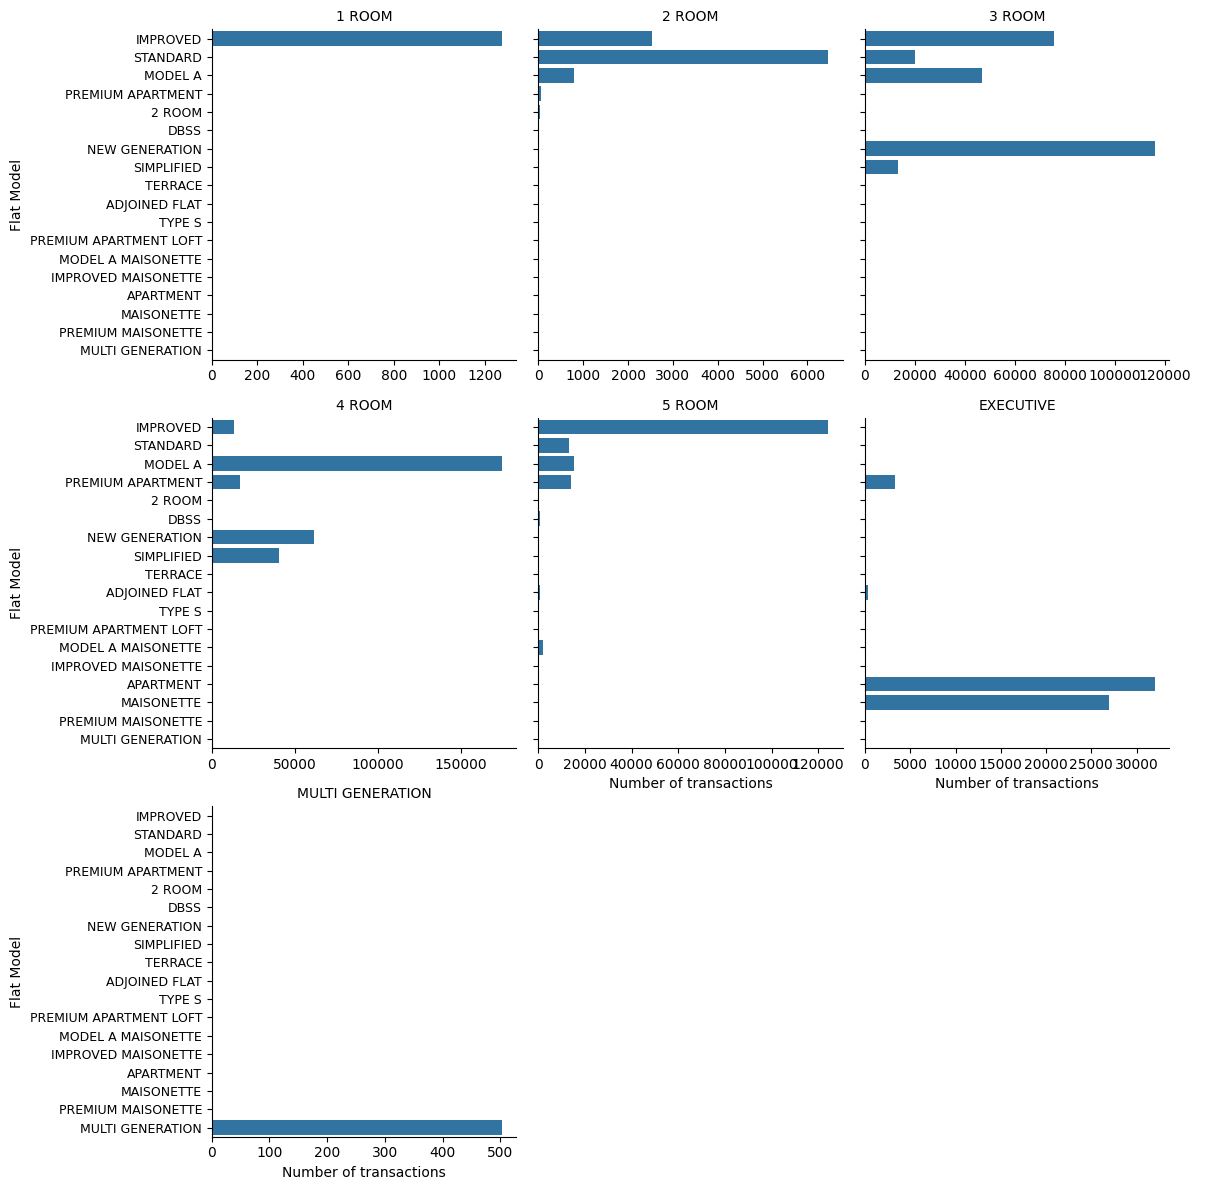

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

g = sns.catplot(
    data=flat_type_model_counts,
    x="count",
    y="flat_model",
    col="flat_type",
    kind="bar",
    col_wrap=3,
    sharex=False,
    height=4
)

g.set_titles("{col_name}")
g.set_axis_labels("Number of transactions", "Flat Model")

for ax in g.axes.flatten():
    ax.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()


The flat model distribution is highly imbalanced within each flat type, with a small number of dominant models accounting for most transactions. This suggests that aggressive one-hot encoding of flat_model may introduce noise and sparsity.

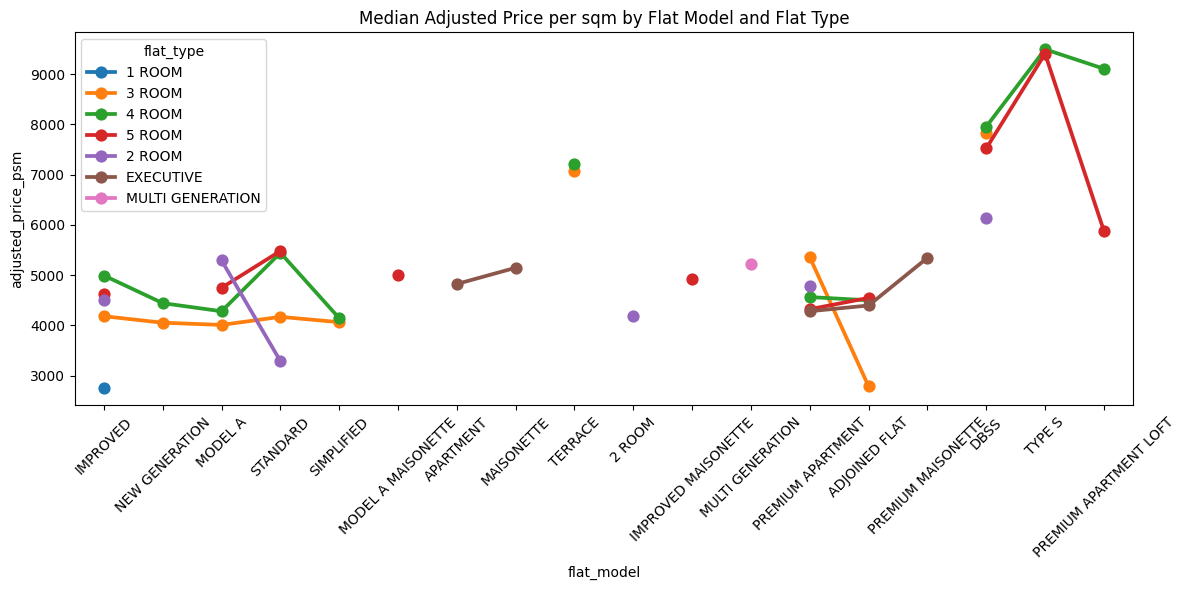

In [17]:
plt.figure(figsize=(12, 6))

sns.pointplot(
    data=df,
    x="flat_model",
    y="adjusted_price_psm",
    hue="flat_type",
    estimator="median",
    errorbar=None
)

plt.xticks(rotation=45)
plt.title("Median Adjusted Price per sqm by Flat Model and Flat Type")
plt.tight_layout()
plt.show()



Price per sqm generally increases with flat size:
1–2 room flats are cheapest, followed by 3-room, 4-room, 5-room, and then Executive / Multi-Generation flats.

Flat model also matters:
For the same flat type, Premium, DBSS, Maisonette, and Type S models tend to have higher prices per sqm than older models like Improved, Standard, or Simplified.

Older flat models are cheaper:
Models such as Improved, New Generation, and Standard consistently have lower median prices per sqm, reflecting older designs and locations.

Newer / special designs command a premium:
DBSS, Premium Apartment, Premium Apartment Loft, Type S show the highest prices, especially for 4-room and 5-room flats.

Variation within the same flat type suggests that flat model captures design quality and age effects beyond flat size alone.

Both flat size and flat model strongly influence resale prices, with newer and premium models consistently commanding higher prices per sqm than older designs.

### onemap api to get longtitude and latitude and postal code from address



In [ ]:

import requests
url = "https://www.onemap.gov.sg/api/auth/post/getToken"
            
payload = {
              "email": 'your_email',
              "password": 'your_password'
            }
            
response = requests.request("POST", url, json=payload)
            
print(response.text)

access_token = "your_access_token"


import os
url = "https://www.onemap.gov.sg/api/common/elastic/search?searchVal=228089&returnGeom=Y&getAddrDetails=Y&pageNum=1"
      
headers = {"Authorization": access_token}
      
response = requests.get(url, headers=headers)
      
print(response.text)


import time

def call_url(full_address, attempts=1, delay=5):
    url = (
        "https://www.onemap.gov.sg/api/common/elastic/search"
        f"?searchVal={full_address}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    )
    headers = {"Authorization": access_token}

    for _ in range(attempts):
        try:
            r = requests.get(url, headers=headers, timeout=10)
            result = r.json()
            if r.status_code == 200 and result['found'] >=1:
                return result['results'][0]
        except Exception:
            return "not found"
        time.sleep(delay)

    return None


result = call_url("ANG MO KIO AVEnue 3")



{
  "error": "Your email address is invalid."
}
{
  "error": "Invalid authentication token. Please register for an account and provide a valid API token.",
  "found": 1,
  "totalNumPages": 1,
  "pageNum": 1,
  "results": [
    {
      "SEARCHVAL": "WILKIE COURT",
      "BLK_NO": "97",
      "ROAD_NAME": "WILKIE ROAD",
      "BUILDING": "WILKIE COURT",
      "ADDRESS": "97 WILKIE ROAD WILKIE COURT SINGAPORE 228089",
      "POSTAL": "228089",
      "X": "29497.3997462066",
      "Y": "31731.1943789013",
      "LATITUDE": "1.30324012981857",
      "LONGITUDE": "103.846773407007"
    }
  ]
}


### onemap function to get hdb houseing postal code and longtitude and latitude

In [ ]:

df["full_address"] = df["block"].astype(str) + " " + df["street_name"]

unique_full_address =  df['full_address'].unique()


from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import quote



def call_url_one(address, session, attempts=2, delay=0.2):
    # URL-encode the query so spaces etc won’t break
    q = quote(str(address))
    url = (
        "https://www.onemap.gov.sg/api/common/elastic/search"
        f"?searchVal={q}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    )
    headers = {"Authorization": access_token}

    for i in range(attempts):
        try:
            r = session.get(url, headers=headers, timeout=5)
            if r.status_code == 200:
                data = r.json()
                if data.get("found", 0) >= 1:
                    return data["results"][0]   # first match JSON
                return None
        except Exception:
            pass
        time.sleep(delay)
    return None


def fetch_onemap_for_addresses(addresses, max_workers=20):
    rows = []

    addresses = list(pd.Series(addresses).dropna().unique())

    with requests.Session() as session:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {
                executor.submit(call_url_one, addr, session): addr
                for addr in addresses
            }

            for future in as_completed(futures):
                addr = futures[future]
                try:
                    result = future.result()
                except Exception:
                    result = None

                rows.append({
                    "full_address": addr,
                    "onemap_result": result
                })
    return pd.DataFrame(rows)

geo_df = fetch_onemap_for_addresses(unique_full_address, max_workers=20)

geo_df['hdb_LATITUDE'] = geo_df['onemap_result'].apply(
    lambda x: x.get('LATITUDE') if isinstance(x, dict) else None
)
geo_df['hdb_LONGITUDE'] = geo_df['onemap_result'].apply(
    lambda x: x.get('LONGITUDE') if isinstance(x, dict) else None
)

geo_df['hdb_POSTAL'] = geo_df['onemap_result'].apply(
    lambda x: x.get('POSTAL') if isinstance(x, dict) else None
)

geo_df['hdb_LATITUDE'] = pd.to_numeric(geo_df['hdb_LATITUDE'], errors='coerce')
geo_df['hdb_LONGITUDE'] = pd.to_numeric(geo_df['hdb_LONGITUDE'], errors='coerce')
geo_df['hdb_POSTAL'] = pd.to_numeric(geo_df['hdb_POSTAL'], errors='coerce')

geo_df.to_csv("data/geo_df1.csv", index=False)


In [20]:
geo_df = pd.read_csv("data/geo_df1.csv")

In [21]:
geo_df

,full_address,onemap_result,hdb_LATITUDE,hdb_LONGITUDE,hdb_POSTAL
0,309 ANG MO KIO AVE 1,"{'SEARCHVAL': 'HORIZON GARDENS', 'BLK_NO': '30...",1.377017,103.834733,569953.0
1,232 ANG MO KIO AVE 3,"{'SEARCHVAL': 'KEBUN BARU PALM VIEW', 'BLK_NO'...",1.368346,103.837196,560232.0
2,346 ANG MO KIO AVE 3,"{'SEARCHVAL': 'TECK GHEE EVERGREEN', 'BLK_NO':...",1.367096,103.849662,560346.0
3,308 ANG MO KIO AVE 1,"{'SEARCHVAL': 'TECK GHEE VISTA', 'BLK_NO': '30...",1.365697,103.844347,563308.0
4,129 ANG MO KIO AVE 3,"{'SEARCHVAL': 'YIO CHU KANG VILLE', 'BLK_NO': ...",1.369895,103.842059,560129.0
...,...,...,...,...,...
9274,470C FERNVALE LINK,"{'SEARCHVAL': 'FERNVALE RIVERGROVE', 'BLK_NO':...",1.396194,103.879992,793470.0
9275,679B PUNGGOL DR,"{'SEARCHVAL': 'WATERWAY BROOKS', 'BLK_NO': '67...",1.406317,103.908463,822679.0
9276,679C PUNGGOL DR,"{'SEARCHVAL': 'WATERWAY BROOKS', 'BLK_NO': '67...",1.406414,103.908806,823679.0
9277,468A FERNVALE LINK,"{'SEARCHVAL': 'FERNVALE LEA', 'BLK_NO': '468A'...",1.397479,103.878500,791468.0


In [22]:
df = df.merge(geo_df, on="full_address", how="left")
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'year', 'remaining_lease_years', 'quarter', 'rpi', 'adjusted_price',
       'adjusted_price_psm', 'storey_mid', 'full_address', 'onemap_result',
       'hdb_LATITUDE', 'hdb_LONGITUDE', 'hdb_POSTAL'],
      dtype='object')

In [23]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'year', 'remaining_lease_years', 'quarter', 'rpi', 'adjusted_price',
       'adjusted_price_psm', 'storey_mid', 'full_address', 'onemap_result',
       'hdb_LATITUDE', 'hdb_LONGITUDE', 'hdb_POSTAL'],
      dtype='object')

### I want to check the characteristics of failed geocoding extraction from onemap 

In [ ]:

df_temp = df.merge(geo_df, on="full_address", how="left")
df_merged_missing = df_temp[df_temp['hdb_LONGITUDE_y'].isna()]

street_summary = (
    df_merged_missing
      .assign(block_num=df_merged_missing["block"].astype(str).str.extract(r"(\d+)")[0])
      .groupby("street_name")
      .agg(
          min_year=("year", "min"),
          max_year=("year", "max"),
          num_unique_addresses=("full_address", "nunique"),
          blocks=("block_num", lambda s: sorted(s.dropna().unique(), key=lambda x: int(x))),
          lease_commence_dates = ("lease_commence_date", lambda s: sorted(s.dropna().unique(), key=lambda x: int(x))),
      )
      .reset_index()
      .sort_values(["num_unique_addresses", "max_year"], ascending=[False, False])
)

street_summary

pd.set_option('display.max_colwidth', 10000)
#display(street_summary)
street_summary

,street_name,min_year,max_year,num_unique_addresses,blocks,lease_commence_dates
35,REDHILL CL,1990,2012,19,"[1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22]",[1983]
42,TEBAN GDNS RD,1990,2007,7,"[3, 5, 6, 7, 10, 13, 14]","[1977, 1978]"
8,BOON LAY DR,1990,2012,6,"[167, 168, 169, 170, 171, 172]",[1974]
12,C'WEALTH DR,1990,2008,5,"[76, 77, 78, 79, 80]",[1969]
13,CLEMENTI AVE 1,1990,2007,5,"[401, 402, 403, 407, 409]",[1978]
26,KG BAHRU HILL,1990,2006,5,"[18, 19, 22, 23, 24]",[1979]
9,BT MERAH VIEW,1990,2010,4,"[110, 111, 113, 114]",[1974]
48,ZION RD,1990,2006,4,"[88, 89, 90, 91]","[1973, 1982]"
19,DOVER RD,1990,2004,4,"[31, 35, 36, 38]",[1978]
41,TANGLIN HALT RD,1990,2003,4,"[51, 52, 53, 54]","[1967, 1969]"



I was unable to obtain a few records for the geomapping from onemap, for example:
REDHILL CL 19 different blocks on Redhill Close 

TEBAN GDNS RD 7 different

BOON LAY DR 6 different blocks 

C'WEALTH DR 5 different blocks

KG BAHRU HILL 5 different blocks

Several streets (e.g. Redhill Close, Teban Gardens Road, Boon Lay Drive, Commonwealth Drive, Kg Bahru Hill) have a high number of unresolved or inconsistent block addresses.

These correspond to early public housing estates that have undergone redevelopment or renaming.

These streets correspond to very old HDB estates built in the 1970s, many of which have undergone redevelopment, renaming, or SERS over time. As a result, block numbers and addresses may no longer match modern geocoding records.

Because these inconsistencies are structural (caused by redevelopment rather than missing data), the affected records were retained but not imputed, to avoid introducing artificial location noise into the dataset.

Streets with many unresolved addresses are mainly early HDB estates that have been redeveloped or renamed over time; these records were kept but not imputed to avoid geocoding noise.

https://www.housingmap.sg/sers/. 


### # Get mrt langtitude and latitude

We assume that MRT accessibility is an important determinant of resale flat prices, as it improves connectivity and reduces commuting cost. Rather than estimating a causal effect of specific MRT lines, we incorporate MRT accessibility as time-aware features in the predictive model.
https://smrt-stations.fandom.com/wiki/East_West_Line_MRT_Stations(Correct)
Given data availability and the long planning horizon of housing decisions, we model MRT availability at the year level.

### This MRT list has the station name, station code and year of start of operation

In [ ]:


from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import quote

def call_url_one(address, session, attempts=2, delay=0.2):
    # URL-encode the query so spaces etc won’t break
    q = quote(str(address))
    url = (
        "https://www.onemap.gov.sg/api/common/elastic/search"
        f"?searchVal={q}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    )
    headers = {"Authorization": access_token}

    for i in range(attempts):
        try:
            r = session.get(url, headers=headers, timeout=5)
            if r.status_code == 200:
                data = r.json()
                if data.get("found", 0) >= 1:
                    return data["results"][0]   # first match JSON
                return None
        except Exception:
            pass
        time.sleep(delay)
    return None


def fetch_onemap_for_addresses(addresses, max_workers=20):
    rows = []

    addresses = list(pd.Series(addresses).dropna().unique())

    with requests.Session() as session:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {
                executor.submit(call_url_one, addr, session): addr
                for addr in addresses
            }

            for future in as_completed(futures):
                addr = futures[future]
                try:
                    result = future.result()
                except Exception:
                    result = None

                rows.append({
                    "Station_code": addr,
                    "onemap_result": result
                })

    return pd.DataFrame(rows)


mrt_df = pd.read_csv("data/mrt.csv")

mrt_names = mrt_df['Station_code']

mrt_with_address = fetch_onemap_for_addresses(mrt_names, max_workers=20)

mrt_with_address = mrt_with_address.rename(columns = {'onemap_result':'MRT_onemap_result'})

mrt_df = mrt_df.merge(mrt_with_address, on = 'Station_code', how ='left')

mrt_df['mrt_LATITUDE'] = mrt_df['MRT_onemap_result'].apply(lambda x: x['LATITUDE'])
mrt_df['mrt_LONGITUDE'] = mrt_df['MRT_onemap_result'].apply(lambda x: x['LONGITUDE'])
mrt_df.drop(columns = ['MRT_onemap_result'], inplace= True)

mrt_df.to_csv("data/mrt_df.csv",index=False)


mrt_df = pd.read_csv("data/mrt_df.csv")
mrt_df

,MRT_name,Station_code,mrt_start_year,mrt_line_type,mrt_LATITUDE,mrt_LONGITUDE
0,Jurong East,NS1,1990,NS,1.333028,103.742370
1,Bukit Batok,NS2,1990,NS,1.349033,103.749566
2,Bukit Gombak,NS3,1990,NS,1.358612,103.751791
3,Choa Chu Kang,NS4,1990,NS,1.385363,103.744371
4,Yew Tee,NS5,1996,NS,1.397535,103.747405
...,...,...,...,...,...,...
141,Bayfront,CE1,2012,CC,1.281874,103.859080
142,Marina Bay,CE2,2012,CC,1.276251,103.855447
143,Woodlands North,TE1,2020,TE,1.448292,103.785693
144,Woodlands,TE2,2020,TE,1.436058,103.787939


### we want to create feature nearest_mrt_dist_km from hdb to the nearest mrt that are availabe at that year point

In [ ]:

from sklearn.neighbors import BallTree

EARTH_RADIUS_KM = 6371.0088
CHUNK = 200_000  

df = df.copy()
df["hdb_LATITUDE"] = pd.to_numeric(df["hdb_LATITUDE"], errors="coerce")
df["hdb_LONGITUDE"] = pd.to_numeric(df["hdb_LONGITUDE"], errors="coerce")
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")  # nullable int

mrt_df = mrt_df.copy()
mrt_df["mrt_LATITUDE"] = pd.to_numeric(mrt_df["mrt_LATITUDE"], errors="coerce")
mrt_df["mrt_LONGITUDE"] = pd.to_numeric(mrt_df["mrt_LONGITUDE"], errors="coerce")
mrt_df["mrt_start_year"] = pd.to_numeric(mrt_df["mrt_start_year"], errors="coerce").astype("Int64")

# drop broken mrt rows
mrt_df = mrt_df.dropna(subset=["mrt_LATITUDE", "mrt_LONGITUDE", "mrt_start_year"]).copy()
mrt_df["mrt_start_year"] = mrt_df["mrt_start_year"].astype(int)

# sort MRT by start year once 
mrt_df = mrt_df.sort_values("mrt_start_year").reset_index(drop=True)
mrt_start = mrt_df["mrt_start_year"].to_numpy()
mrt_coords_rad = np.deg2rad(mrt_df[["mrt_LATITUDE", "mrt_LONGITUDE"]].to_numpy())

# output
nearest_mrt_dist_km = np.full(len(df), np.nan, dtype=np.float32)

nearest_mrt_name = np.full(len(df), None, dtype=object)

# valid rows
valid_mask = (
    df["hdb_LATITUDE"].notna()
    & df["hdb_LONGITUDE"].notna()
    & df["year"].notna()
)
valid_idx = df.index[valid_mask].to_numpy()
year_arr = df.loc[valid_mask, "year"].astype(int).to_numpy()

# unique years to process
unique_years = np.sort(np.unique(year_arr))

# cache trees per year 
tree_cache = {}

for y in unique_years:
    # only stations open by year y
    pos = np.searchsorted(mrt_start, y, side="right")
    if pos == 0:
        continue  # no MRT existed yet

    # build / reuse tree for this year
    if y not in tree_cache:
        tree_cache[y] = BallTree(mrt_coords_rad[:pos], metric="haversine")
    tree = tree_cache[y]

    # indices in df for this year
    idxs = valid_idx[year_arr == y]
    coords = np.deg2rad(df.loc[idxs, ["hdb_LATITUDE", "hdb_LONGITUDE"]].to_numpy())

    # chunk query
    for start in range(0, len(idxs), CHUNK):
        end = start + CHUNK
        idx_chunk = idxs[start:end]
        coord_chunk = coords[start:end]

        dist_rad, ind = tree.query(coord_chunk, k=1)
        nearest_mrt_dist_km[idx_chunk] = (dist_rad[:, 0] * EARTH_RADIUS_KM).astype(np.float32)

        
        nearest_mrt_name[idx_chunk] = mrt_df.loc[ind[:, 0], "MRT_name"].to_numpy(dtype=object)

# attach
df["nearest_mrt_dist_km"] = nearest_mrt_dist_km
df["nearest_mrt_name"] = nearest_mrt_name 

df[["year", "nearest_mrt_name", "nearest_mrt_dist_km"]].head()


,year,nearest_mrt_name,nearest_mrt_dist_km
0,1990,Yio Chu Kang,1.251742
1,1990,Yio Chu Kang,1.251742
2,1990,Yio Chu Kang,1.251742
3,1990,Yio Chu Kang,1.251742
4,1990,Ang Mo Kio,0.986904


In [27]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'year', 'remaining_lease_years', 'quarter', 'rpi', 'adjusted_price',
       'adjusted_price_psm', 'storey_mid', 'full_address', 'onemap_result',
       'hdb_LATITUDE', 'hdb_LONGITUDE', 'hdb_POSTAL', 'nearest_mrt_dist_km',
       'nearest_mrt_name'],
      dtype='object')

In [28]:
df["nearest_mrt_dist_km"].describe()

count    816010.000000
mean          1.072546
std           0.900130
min           0.036138
25%           0.528425
50%           0.822008
75%           1.239238
max           7.300477
Name: nearest_mrt_dist_km, dtype: float64

### Create feature of nearest primary school and number of primary school within 1 km
primary school list https://data.gov.sg/datasets/d_688b934f82c1059ed0a6993d2a829089/view

In [ ]:

from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import quote

def call_url_one(address, session, attempts=2, delay=0.2):
    # URL-encode the query so spaces etc won’t break
    q = quote(str(address))
    url = (
        "https://www.onemap.gov.sg/api/common/elastic/search"
        f"?searchVal={q}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    )
    headers = {"Authorization": access_token}

    for i in range(attempts):
        try:
            r = session.get(url, headers=headers, timeout=5)
            if r.status_code == 200:
                data = r.json()
                if data.get("found", 0) >= 1:
                    return data["results"][0]   # first match JSON
                return None
        except Exception:
            pass
        time.sleep(delay)
    return None


def fetch_onemap_for_addresses(addresses, max_workers=20):
    rows = []

    addresses = list(pd.Series(addresses).dropna().unique())

    with requests.Session() as session:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {
                executor.submit(call_url_one, addr, session): addr
                for addr in addresses
            }

            for future in as_completed(futures):
                addr = futures[future]
                try:
                    result = future.result()
                except Exception:
                    result = None

                rows.append({
                    "school_name": addr,
                    "onemap_result": result
                })

    return pd.DataFrame(rows)


schools = pd.read_csv("data/Generalinformationofschools.csv")

schools = schools[['school_name','address','mainlevel_code','sap_ind','autonomous_ind']]

primary_school_df = schools[schools["mainlevel_code"].isin(["PRIMARY", "MIXED LEVEL (P1-S4)"])]
primary_school_list = primary_school_df['school_name']

primary_list_with_address = fetch_onemap_for_addresses(primary_school_list, max_workers=20)
primary_list_with_address=primary_list_with_address.rename(columns = {'onemap_result':'primary_school_onemap_result'})
primary_school_df = primary_school_df.merge(primary_list_with_address, on = 'school_name', how ='left')

primary_school_df['primary_school_LATITUDE'] = primary_school_df['primary_school_onemap_result'].apply(lambda x: x['LATITUDE'])
primary_school_df['primary_school_LONGITUDE'] = primary_school_df['primary_school_onemap_result'].apply(lambda x: x['LONGITUDE'])
primary_school_df.drop(columns = ['primary_school_onemap_result'], inplace= True)
primary_school_df.to_csv("data/primary_school_df.csv",index=False)


primary_df = pd.read_csv("data/primary_school_df.csv")
primary_df


,school_name,address,mainlevel_code,sap_ind,autonomous_ind,primary_school_LATITUDE,primary_school_LONGITUDE
0,ADMIRALTY PRIMARY SCHOOL,11 WOODLANDS CIRCLE,PRIMARY,No,No,1.442635,103.800040
1,AHMAD IBRAHIM PRIMARY SCHOOL,10 YISHUN STREET 11,PRIMARY,No,No,1.433153,103.832942
2,AI TONG SCHOOL,100 Bright Hill Drive,PRIMARY,Yes,No,1.360583,103.833020
3,ALEXANDRA PRIMARY SCHOOL,2A Prince Charles Crescent,PRIMARY,No,No,1.291334,103.824425
4,ANCHOR GREEN PRIMARY SCHOOL,31 Anchorvale Drive,PRIMARY,No,No,1.390370,103.887165
...,...,...,...,...,...,...,...
177,YUHUA PRIMARY SCHOOL,158 JURONG EAST STREET 24,PRIMARY,No,No,1.342802,103.741106
178,YUMIN PRIMARY SCHOOL,3 TAMPINES STREET 21,PRIMARY,No,No,1.351292,103.950462
179,ZHANGDE PRIMARY SCHOOL,51 Jalan Membina,PRIMARY,No,No,1.284212,103.825952
180,ZHENGHUA PRIMARY SCHOOL,9 Fajar Road,PRIMARY,No,No,1.379549,103.769314


In [ ]:

from sklearn.neighbors import BallTree

EARTH_RADIUS_KM = 6371.0088
RADIUS_KM = 1.0
RADIUS_RAD = RADIUS_KM / EARTH_RADIUS_KM

df = df.copy()

# numeric + keep NaNs
df["hdb_LATITUDE"] = pd.to_numeric(df["hdb_LATITUDE"], errors="coerce")
df["hdb_LONGITUDE"] = pd.to_numeric(df["hdb_LONGITUDE"], errors="coerce")

primary_df = primary_df.copy()
primary_df["primary_school_LATITUDE"] = pd.to_numeric(primary_df["primary_school_LATITUDE"], errors="coerce")
primary_df["primary_school_LONGITUDE"] = pd.to_numeric(primary_df["primary_school_LONGITUDE"], errors="coerce")
primary_df = primary_df.dropna(subset=["primary_school_LATITUDE", "primary_school_LONGITUDE"]).reset_index(drop=True)

# Build BallTree once
school_coords_rad = np.deg2rad(
    primary_df[["primary_school_LATITUDE", "primary_school_LONGITUDE"]].to_numpy()
)
tree = BallTree(school_coords_rad, metric="haversine")

# Prepare outputs
n = len(df)
nearest_primary_dist_km = np.full(n, np.nan, dtype=np.float32)
nearest_primary_name = np.full(n, None, dtype=object)
primary_count_within = np.full(n, np.nan, dtype=np.float32)

valid_mask = df["hdb_LATITUDE"].notna() & df["hdb_LONGITUDE"].notna()
valid_idx = df.index[valid_mask].to_numpy()

# Query in chunks 
CHUNK = 200_000
coords_all = np.deg2rad(df.loc[valid_idx, ["hdb_LATITUDE", "hdb_LONGITUDE"]].to_numpy())

for start in range(0, len(valid_idx), CHUNK):
    end = start + CHUNK
    idx_chunk = valid_idx[start:end]
    coord_chunk = coords_all[start:end]

    # 1) nearest primary distance + name
    dist_rad, ind = tree.query(coord_chunk, k=1)
    nearest_primary_dist_km[idx_chunk] = (dist_rad[:, 0] * EARTH_RADIUS_KM).astype(np.float32)
    nearest_primary_name[idx_chunk] = primary_df.loc[ind[:, 0], "school_name"].to_numpy(dtype=object)

    # 2) count within radius
    primary_count_within[idx_chunk] = tree.query_radius(
        coord_chunk, r=RADIUS_RAD, count_only=True
    ).astype(np.float32)

# Attach features
df["nearest_primary_dist_km"] = nearest_primary_dist_km
df["nearest_primary_name"] = nearest_primary_name  
df[f"primary_count_within_{RADIUS_KM}km"] = primary_count_within
df[["nearest_primary_name", "nearest_primary_dist_km", f"primary_count_within_{RADIUS_KM}km"]].head()

,nearest_primary_name,nearest_primary_dist_km,primary_count_within_1.0km
0,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.397193,2.0
1,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.397193,2.0
2,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.397193,2.0
3,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.397193,2.0
4,ANG MO KIO PRIMARY SCHOOL,0.405152,1.0


In [31]:
df["nearest_primary_dist_km"].describe()

count    816010.000000
mean          0.418873
std           0.249396
min           0.042776
25%           0.243207
50%           0.371535
75%           0.536378
max           5.144551
Name: nearest_primary_dist_km, dtype: float64

### Plot the mrt and primary school features vs target

C:\Users\Jiany\AppData\Local\Temp\ipykernel_32008\3588087594.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("mrt_dist_bin")["adjusted_price_psm"]


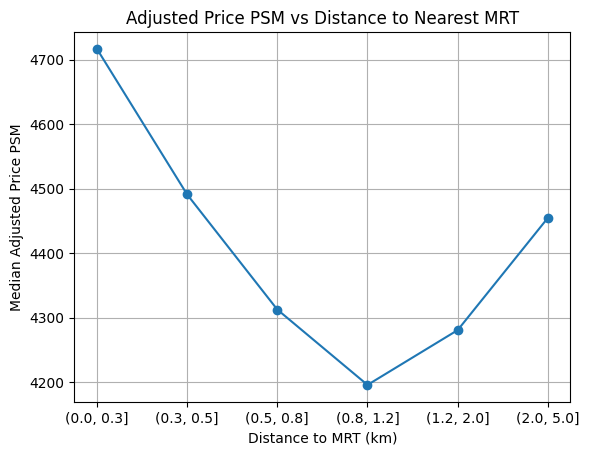

C:\Users\Jiany\AppData\Local\Temp\ipykernel_32008\3588087594.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("pri_dist_bin")["adjusted_price_psm"]


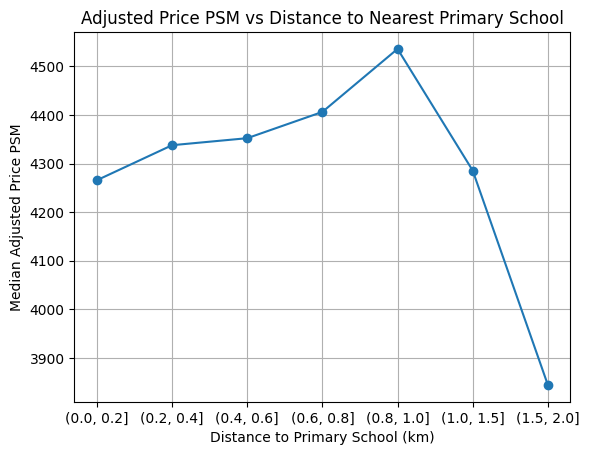

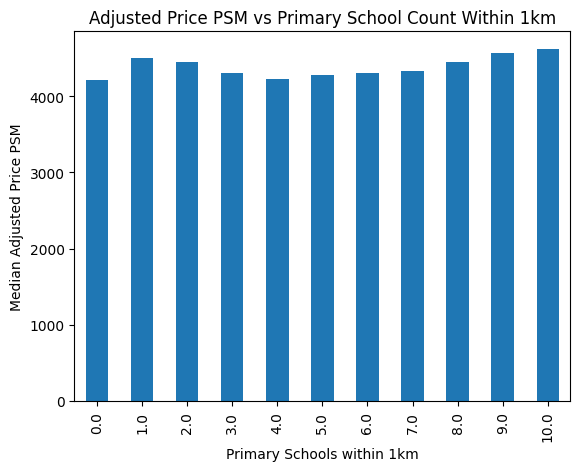

In [32]:

import matplotlib.pyplot as plt

# 1) adjusted_price_psm vs nearest MRT distance

(
    df
    .loc[
        df["adjusted_price_psm"].notna() &
        df["nearest_mrt_dist_km"].notna() &
        (df["nearest_mrt_dist_km"] <= 5)
    ]
    .assign(
        mrt_dist_bin=pd.cut(
            df["nearest_mrt_dist_km"],
            bins=[0, 0.3, 0.5, 0.8, 1.2, 2.0, 5.0]
        )
    )
    .groupby("mrt_dist_bin")["adjusted_price_psm"]
    .median()
    .plot(marker="o", title="Adjusted Price PSM vs Distance to Nearest MRT")
)
plt.xlabel("Distance to MRT (km)")
plt.ylabel("Median Adjusted Price PSM")
plt.grid(True)
plt.show()



# adjusted_price_psm vs nearest primary distance

(
    df
    .loc[
        df["adjusted_price_psm"].notna() &
        df["nearest_primary_dist_km"].notna() &
        (df["nearest_primary_dist_km"] <= 5)
    ]
    .assign(
        pri_dist_bin=pd.cut(
            df["nearest_primary_dist_km"],
            bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0]

        )
    )
    .groupby("pri_dist_bin")["adjusted_price_psm"]
    .median()
    .plot(marker="o", title="Adjusted Price PSM vs Distance to Nearest Primary School")
)
plt.xlabel("Distance to Primary School (km)")
plt.ylabel("Median Adjusted Price PSM")
plt.grid(True)
plt.show()


#adjusted_price_psm vs primary count within 1km

(
    df
    .loc[
        df["adjusted_price_psm"].notna() &
        df["primary_count_within_1.0km"].notna()
    ]
    .groupby("primary_count_within_1.0km")["adjusted_price_psm"]
    .median()
    .plot(kind="bar", title="Adjusted Price PSM vs Primary School Count Within 1km")
)
plt.xlabel("Primary Schools within 1km")
plt.ylabel("Median Adjusted Price PSM")
plt.show()


In [33]:
df.groupby(
    pd.cut(df["nearest_primary_dist_km"],
           bins=[0,0.2,0.4,0.6,0.8,1.0,1.5,2.0])
)["adjusted_price_psm"].agg(["count","median"])

C:\Users\Jiany\AppData\Local\Temp\ipykernel_32008\223095586.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(


,count,median
nearest_primary_dist_km,,
"(0.0, 0.2]",132669,4265.761234
"(0.2, 0.4]",316356,4337.790705
"(0.4, 0.6]",220081,4352.227684
"(0.6, 0.8]",95262,4406.310492
"(0.8, 1.0]",27383,4535.907859
"(1.0, 1.5]",20255,4285.608771
"(1.5, 2.0]",3650,3844.496421


### MRT we observed
High price very close to MRT (0–300m)

Clear drop as distance increases

Lowest around ~0.8–1.2 km

Slight rebound after 2 km

2km bins are often:

mature estates

larger flats

higher floor area

Distance-to-MRT effect saturates, then other factors dominate

Adjusted price per sqm decreases sharply within 1km of MRT, with diminishing marginal impact beyond that.





### Primary schools 
Primary schools are not a uniform amenity like MRT, so proximity does not translate linearly into price.

Very close (0–200m)
Often associated with older HDB blocks, higher noise and traffic, and smaller flat sizes.
As a result, price per sqm can be lower despite close proximity.

Sweet spot (600m–1km)
Walkable distance without noise, and within the typical 1km admission radius, which drives strong family demand.
This creates a peak in prices around the 0.8–1.0 km range, a real behavioural effect.

Beyond 1km
More common in newer or outer towns (e.g., Jurong West, Punggol, Sengkang), where schools are plentiful but not necessarily elite, and overall price levels are lower.
Hence prices drop after 1km.

Overall, primary school proximity exhibits a non-linear sweet-spot effect rather than a monotonic relationship.

### Create a distance to city center feature

In [ ]:
mrt_df[mrt_df.MRT_name == 'Raffles Place']

CITY_LAT = 1.284126
CITY_LON = 103.851462
EARTH_RADIUS_KM = 6371.0088


df["hdb_LATITUDE"] = pd.to_numeric(df["hdb_LATITUDE"], errors="coerce")
df["hdb_LONGITUDE"] = pd.to_numeric(df["hdb_LONGITUDE"], errors="coerce")

# radians
lat1 = np.deg2rad(df["hdb_LATITUDE"].values)
lon1 = np.deg2rad(df["hdb_LONGITUDE"].values)
lat2 = np.deg2rad(CITY_LAT)
lon2 = np.deg2rad(CITY_LON)

# haversine
dlat = lat1 - lat2
dlon = lon1 - lon2

a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

df["dist_to_city_centre_km"] = (EARTH_RADIUS_KM * c).astype("float32")
df


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,onemap_result,hdb_LATITUDE,hdb_LONGITUDE,hdb_POSTAL,nearest_mrt_dist_km,nearest_mrt_name,nearest_primary_dist_km,nearest_primary_name,primary_count_within_1.0km,dist_to_city_centre_km
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,...,"{'SEARCHVAL': 'HORIZON GARDENS', 'BLK_NO': '309', 'ROAD_NAME': 'ANG MO KIO AVENUE 2', 'BUILDING': 'HORIZON GARDENS', 'ADDRESS': '309 ANG MO KIO AVENUE 2 HORIZON GARDENS SINGAPORE 569953', 'POSTAL': '569953', 'X': '28157.4530873811', 'Y': '39889.0057018362', 'LATITUDE': '1.37701651576853', 'LONGITUDE': '103.834733409768'}",1.377017,103.834733,569953.0,1.251742,Yio Chu Kang,0.397193,CHIJ ST. NICHOLAS GIRLS' SCHOOL,2.0,10.495038
1,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,...,"{'SEARCHVAL': 'HORIZON GARDENS', 'BLK_NO': '309', 'ROAD_NAME': 'ANG MO KIO AVENUE 2', 'BUILDING': 'HORIZON GARDENS', 'ADDRESS': '309 ANG MO KIO AVENUE 2 HORIZON GARDENS SINGAPORE 569953', 'POSTAL': '569953', 'X': '28157.4530873811', 'Y': '39889.0057018362', 'LATITUDE': '1.37701651576853', 'LONGITUDE': '103.834733409768'}",1.377017,103.834733,569953.0,1.251742,Yio Chu Kang,0.397193,CHIJ ST. NICHOLAS GIRLS' SCHOOL,2.0,10.495038
2,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,...,"{'SEARCHVAL': 'HORIZON GARDENS', 'BLK_NO': '309', 'ROAD_NAME': 'ANG MO KIO AVENUE 2', 'BUILDING': 'HORIZON GARDENS', 'ADDRESS': '309 ANG MO KIO AVENUE 2 HORIZON GARDENS SINGAPORE 569953', 'POSTAL': '569953', 'X': '28157.4530873811', 'Y': '39889.0057018362', 'LATITUDE': '1.37701651576853', 'LONGITUDE': '103.834733409768'}",1.377017,103.834733,569953.0,1.251742,Yio Chu Kang,0.397193,CHIJ ST. NICHOLAS GIRLS' SCHOOL,2.0,10.495038
3,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,...,"{'SEARCHVAL': 'HORIZON GARDENS', 'BLK_NO': '309', 'ROAD_NAME': 'ANG MO KIO AVENUE 2', 'BUILDING': 'HORIZON GARDENS', 'ADDRESS': '309 ANG MO KIO AVENUE 2 HORIZON GARDENS SINGAPORE 569953', 'POSTAL': '569953', 'X': '28157.4530873811', 'Y': '39889.0057018362', 'LATITUDE': '1.37701651576853', 'LONGITUDE': '103.834733409768'}",1.377017,103.834733,569953.0,1.251742,Yio Chu Kang,0.397193,CHIJ ST. NICHOLAS GIRLS' SCHOOL,2.0,10.495038
4,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,...,"{'SEARCHVAL': 'ANG MO KIO 22', 'BLK_NO': '216', 'ROAD_NAME': 'ANG MO KIO AVENUE 1', 'BUILDING': 'ANG MO KIO 22', 'ADDRESS': '216 ANG MO KIO AVENUE 1 ANG MO KIO 22 SINGAPORE 560216', 'POSTAL': '560216', 'X': '28911.0522399368', 'Y': '38692.6167905722', 'LATITUDE': '1.36619678831054', 'LONGITUDE': '103.841505011903'}",1.366197,103.841505,560216.0,0.986904,Ang Mo Kio,0.405152,ANG MO KIO PRIMARY SCHOOL,1.0,9.192749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09-01,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0,...,"{'SEARCHVAL': 'AAVC-ANIMAL & AVIAN VETERINARY CLINIC', 'BLK_NO': '716', 'ROAD_NAME': 'YISHUN STREET 71', 'BUILDING': 'AAVC-ANIMAL & AVIAN VETERINARY CLINIC', 'ADDRESS': '716 YISHUN STREET 71 AAVC-ANIMAL & AVIAN VETERINARY CLINIC SINGAPORE 760716', 'POSTAL': '760716', 'X': '27375.1923638079', 'Y': '45328.6797767468', 'LATITUDE': '1.42621096565013', 'LONGITUDE': '103.827704108295'}",1.426211,103.827704,760716.0,0.887593,Yishun,0.344245,JIEMIN PRIMARY SCHOOL,2.0,16.018368
826577,2020-09-01,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0,...,"{'SEARCHVAL': '760 YISHUN STREET 72 SINGAPORE 760760', 'BLK_NO': '760', 'ROAD_NAME': 'YISHUN STREET 72', 'BUILDING': 'NIL', 'ADDRESS': '760 YISHUN STREET 72 SINGAPORE 760760', 'POSTAL': '760760', 'X': '27933.9068051465', 'Y': '45282.667628888', 'LATITUDE': '1.42579485526292', 'LONGITUDE': '103.832724670537'}",1.425795,103.832725,760760.0,0.478352,Yis

In [35]:
df["dist_to_city_centre_km"].describe()

count    816010.000000
mean         12.063973
std           4.400446
min           0.584962
25%           9.130517
50%          12.700808
75%          15.453438
max          22.378563
Name: dist_to_city_centre_km, dtype: float64

### Plot price vs distance to city center

C:\Users\Jiany\AppData\Local\Temp\ipykernel_32008\1038354882.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("city_dist_bin")["adjusted_price_psm"]


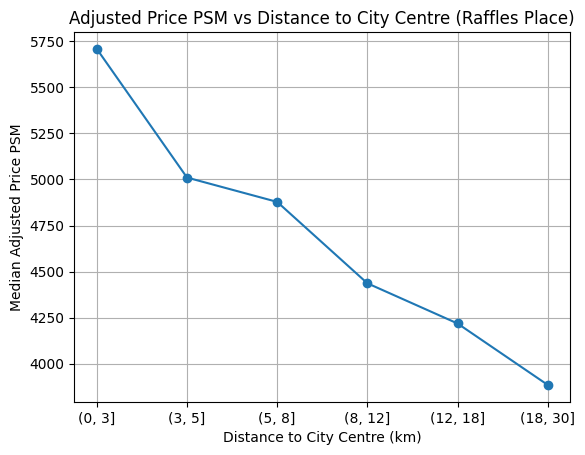

In [36]:


(
    df
    .loc[
        df["adjusted_price_psm"].notna() &
        df["dist_to_city_centre_km"].notna() &
        (df["dist_to_city_centre_km"] <= 30)   # cap extremes
    ]
    .assign(
        city_dist_bin=pd.cut(
            df["dist_to_city_centre_km"],
            bins=[0, 3, 5, 8, 12, 18, 30]
        )
    )
    .groupby("city_dist_bin")["adjusted_price_psm"]
    .median()
    .plot(marker="o")
)

plt.title("Adjusted Price PSM vs Distance to City Centre (Raffles Place)")
plt.xlabel("Distance to City Centre (km)")
plt.ylabel("Median Adjusted Price PSM")
plt.grid(True)
plt.show()


Resale prices per sqm decline steadily with increasing distance from the city centre, with a strong central premium concentrated within the inner 3–5 km.

### Check the Median Resale Price over time

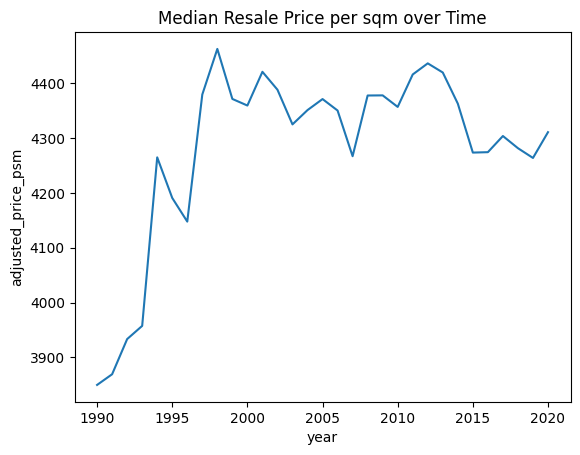

In [37]:

sns.lineplot(
    data=df.groupby('year')['adjusted_price_psm'].median().reset_index(),
    x='year', y='adjusted_price_psm'
)
plt.title('Median Resale Price per sqm over Time')
plt.show()

Resale prices per sqm rose sharply in the early 1990s, peaked around the late 1990s to early 2000s, and thereafter fluctuated within a relatively stable range with cyclical ups and downs.

### Price trend over time by town (top towns only)


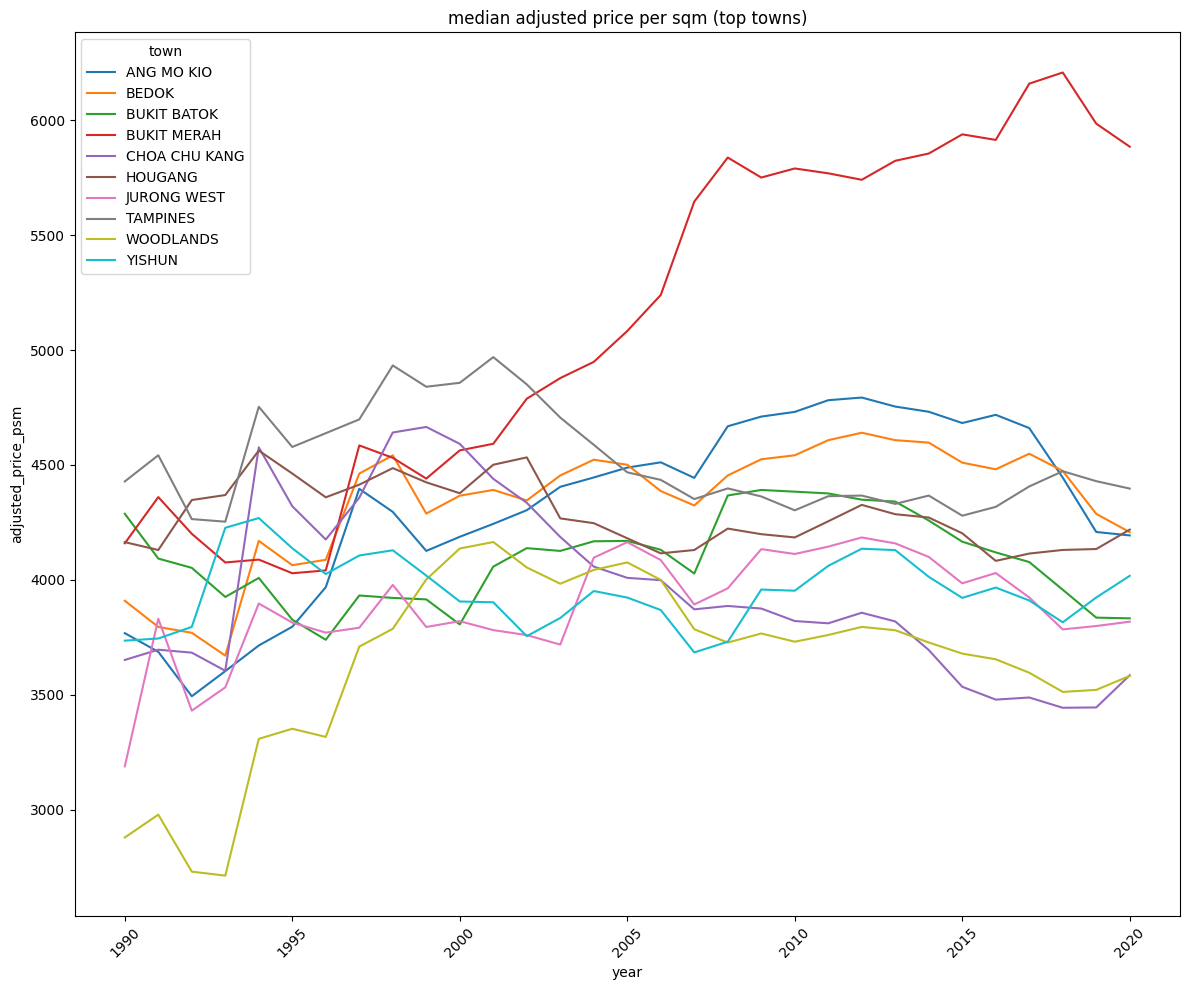

In [38]:
target = "adjusted_price_psm"
top_towns = df["town"].value_counts().head(10).index
tmp = df[df["town"].isin(top_towns)].groupby(["year","town"])[target].median().reset_index()

plt.figure(figsize=(12,10))
sns.lineplot(data=tmp, x="year", y=target, hue="town")
plt.xticks(rotation=45)
plt.title("median adjusted price per sqm (top towns)")
plt.tight_layout()
plt.show()

When broken down by town, price levels and trends differ clearly, with more central or mature towns consistently commanding higher prices than outer towns.
Despite these differences, most towns follow similar cycles over time, suggesting that market-wide factors drive overall movements while location explains persistent price gaps.

### check town vs price per sqm

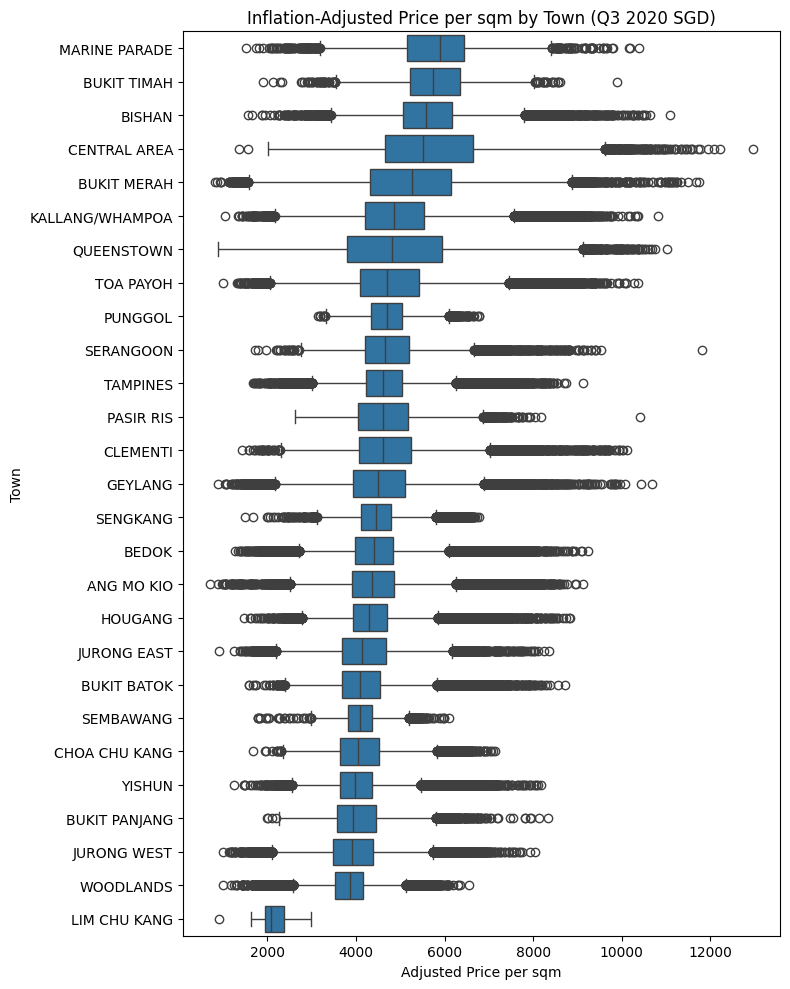

In [39]:
town_order = (
    df.groupby('town')['adjusted_price_psm']
      .median()
      .sort_values(ascending=False)
      .index
)
plt.figure(figsize=(8, 10))

sns.boxplot(
    data=df,
    y='town',
    x='adjusted_price_psm',
    order=town_order
)

plt.title('Inflation-Adjusted Price per sqm by Town (Q3 2020 SGD)')
plt.xlabel('Adjusted Price per sqm')
plt.ylabel('Town')
plt.tight_layout()
plt.show()


Prices per sqm vary widely by town, with central and mature estates like Marine Parade, Bukit Timah, and the Central Area commanding the highest medians.
Mid-tier towns (e.g. Queenstown, Bishan, Kallang/Whampoa) show strong prices but with broader spreads, reflecting mixed flat types and ages.
Outer and newer towns such as Jurong West, Woodlands, and Sembawang generally have lower medians, though price distributions overlap due to factors like flat size, age, and proximity to amenities.

### check storey vs price per sqm

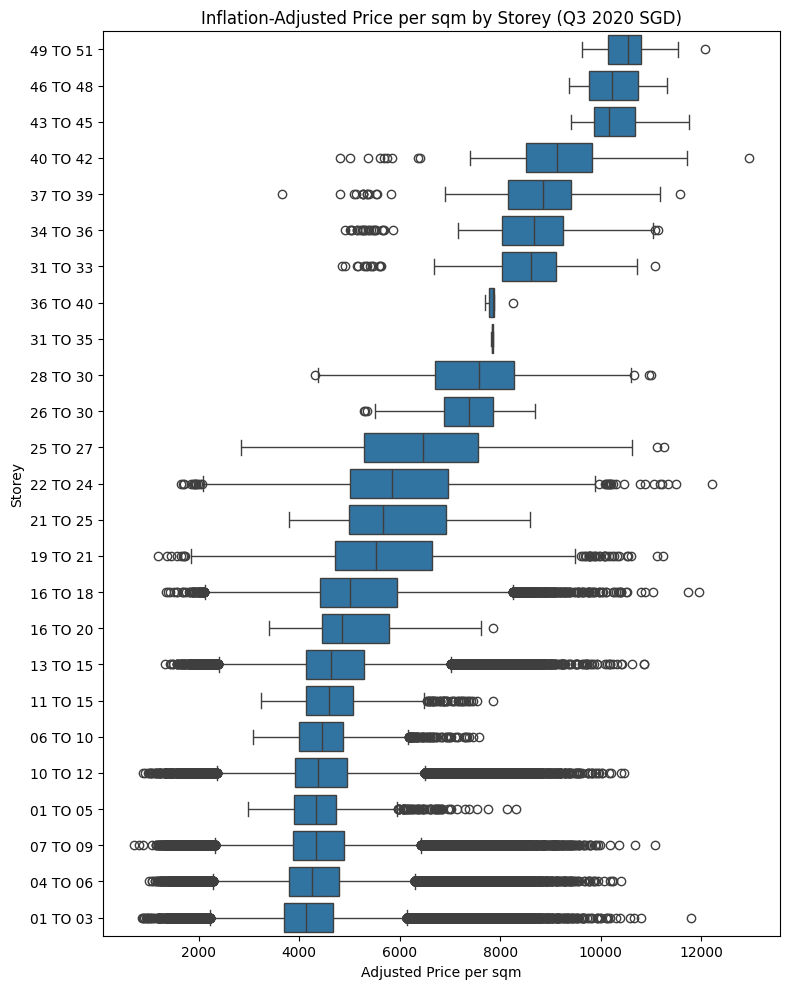

In [40]:
storey_order = (
    df.groupby('storey_range')['adjusted_price_psm']
      .median()
      .sort_values(ascending=False)
      .index
)
plt.figure(figsize=(8,10))

sns.boxplot(
    data=df,
    y='storey_range',
    x='adjusted_price_psm',
    order = storey_order
)

plt.title('Inflation-Adjusted Price per sqm by Storey (Q3 2020 SGD)')
plt.xlabel('Adjusted Price per sqm')
plt.ylabel('Storey')
plt.tight_layout()
plt.show()


Prices per sqm generally increase with storey height, reflecting premiums for better views, ventilation, and reduced noise.
Lower floors tend to be cheaper and show wider variability, while mid-to-high floors cluster at higher price levels.
Very high storeys command the highest medians, though the number of such flats is smaller, leading to tighter but more selective distributions.

### CHECK flat_type vs price per sqm

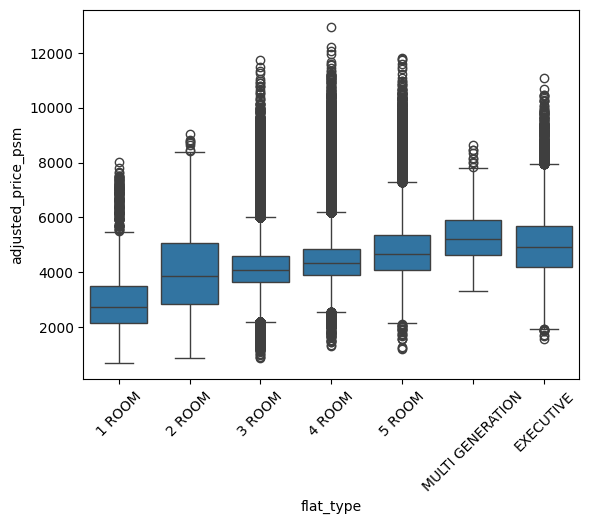

In [41]:

sns.boxplot(data=df, x='flat_type', y='adjusted_price_psm', order = ['1 ROOM','2 ROOM','3 ROOM','4 ROOM','5 ROOM','MULTI GENERATION','EXECUTIVE'])
plt.xticks(rotation=45)
plt.show()

Resale price per sqm increases with flat type, reflecting larger size and better layouts in higher-end units.
Smaller flats (1–2 room) are the cheapest on average, while 4–5 room and executive flats command higher prices.
Price spreads widen for larger flats, showing more variation driven by location, age, and amenities.

In [42]:
df = df[['town', 'flat_type', 'block', 'street_name', 'storey_range','storey_mid', 
       'flat_model', 'lease_commence_date', 'year', 'remaining_lease_years',
       'adjusted_price_psm','full_address','hdb_LATITUDE', 'hdb_LONGITUDE', 'hdb_POSTAL','nearest_mrt_dist_km',
       'nearest_primary_dist_km','dist_to_city_centre_km','floor_area_sqm']]

### Distribution and skweness of numerical features

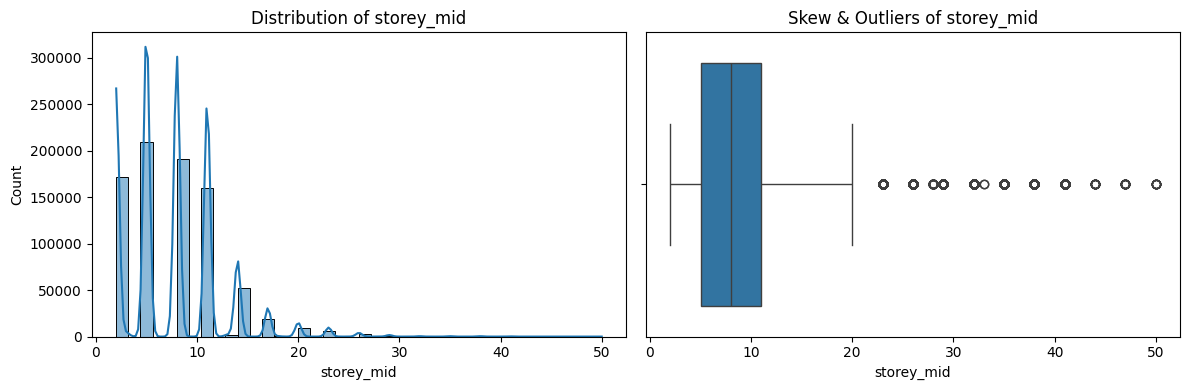

storey_mid skewness: 1.19
--------------------------------------------------


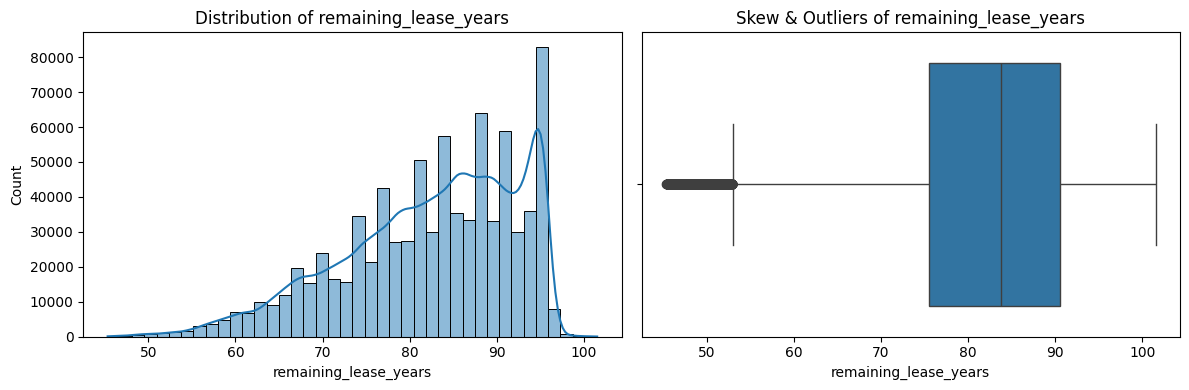

remaining_lease_years skewness: -0.68
--------------------------------------------------


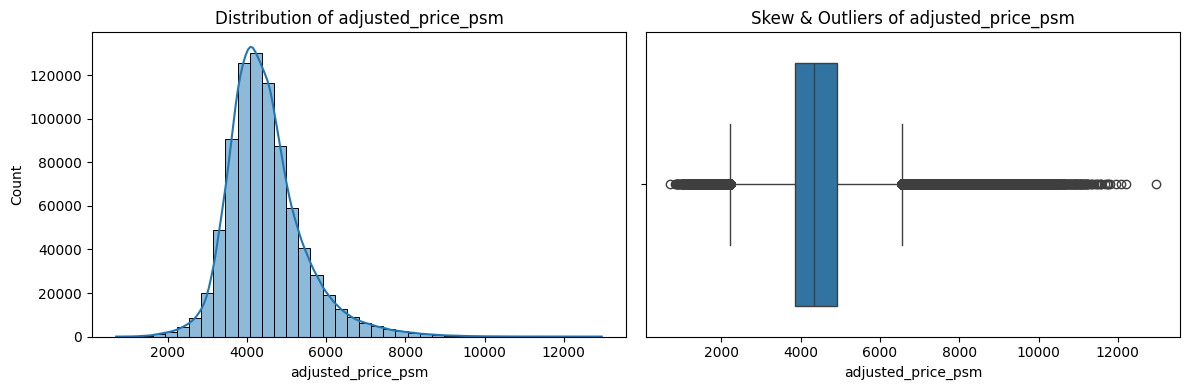

adjusted_price_psm skewness: 1.07
--------------------------------------------------


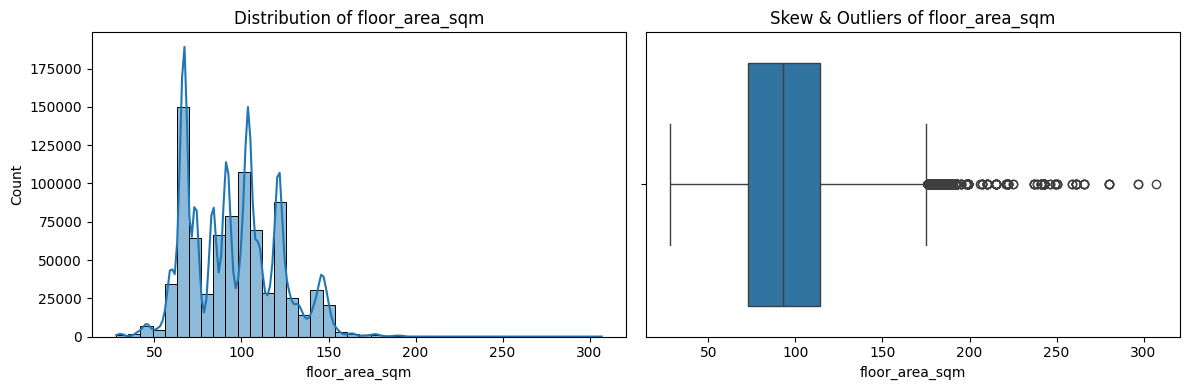

floor_area_sqm skewness: 0.38
--------------------------------------------------


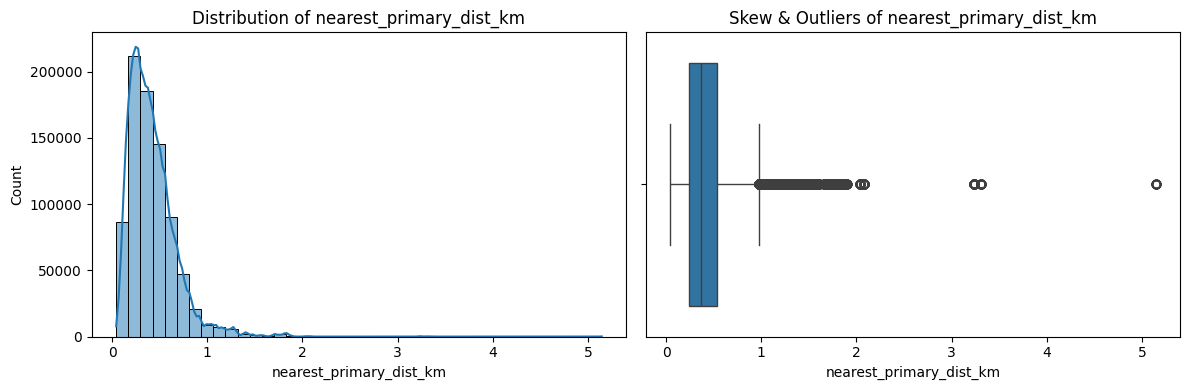

nearest_primary_dist_km skewness: 2.14
--------------------------------------------------


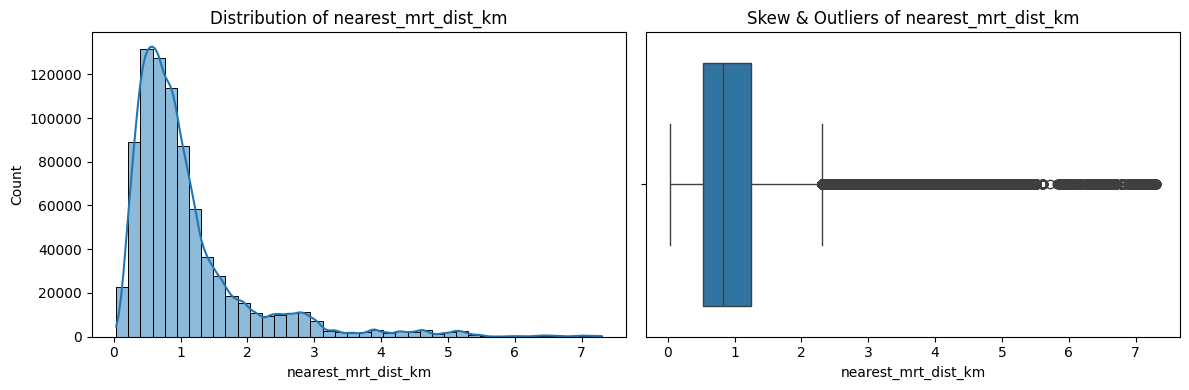

nearest_mrt_dist_km skewness: 2.54
--------------------------------------------------


In [43]:
num_cols =['storey_mid','remaining_lease_years','adjusted_price_psm','floor_area_sqm','nearest_primary_dist_km','nearest_mrt_dist_km']
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram (distribution)
    sns.histplot(df[col].dropna(), bins=40, kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")

    # Boxplot (skew / outliers)
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Skew & Outliers of {col}")

    plt.tight_layout()
    plt.show()

    # Print skewness
    print(f"{col} skewness: {df[col].skew():.2f}")
    print("-" * 50)


Adjusted price per sqm (adjusted_price_psm):
Prices cluster around a central range with a right-skewed tail, indicating a small number of high-priced outliers.

Storey (storey_mid):
Most resale flats are on low to mid floors, with far fewer transactions at very high storeys.

Remaining lease years:
Most resale flats still have a long remaining lease, with transactions concentrated above 60 years.

Nearest MRT distance (nearest_mrt_dist_km):
Most resale flats are located within about 1 km of an MRT station, with far fewer flats located very far away.

Nearest primary school distance (nearest_primary_dist_km):
The majority of flats are very close to a primary school, reflecting dense school coverage across residential areas.

Distance to city centre (dist_to_city_centre_km):
Flats are spread across the island, with most homes located in mid-range distances rather than right in the city core.

Floor area (floor_area_sqm):
Flat sizes cluster around typical HDB layouts, with a long right tail representing larger units such as executive and multi-generation flats.

### check categorical features count

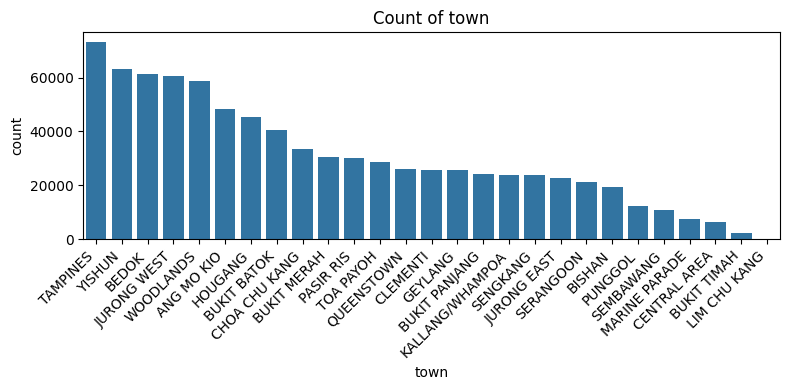

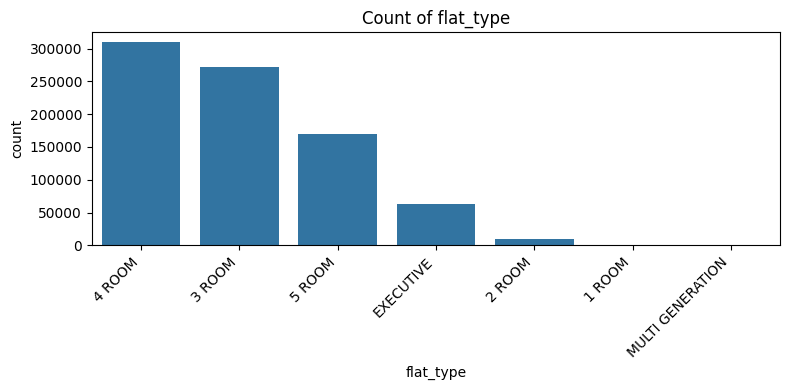

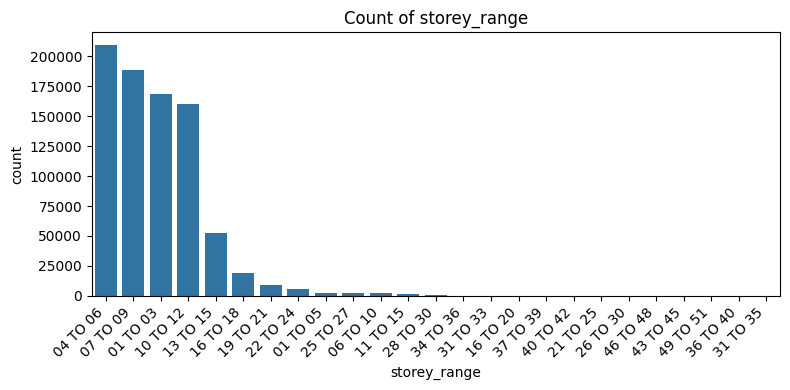

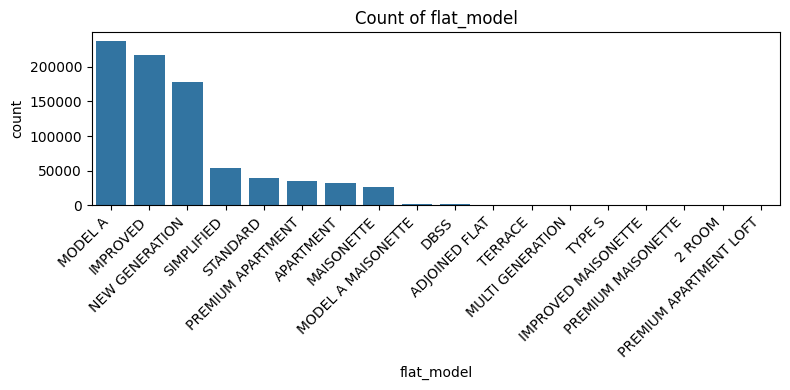

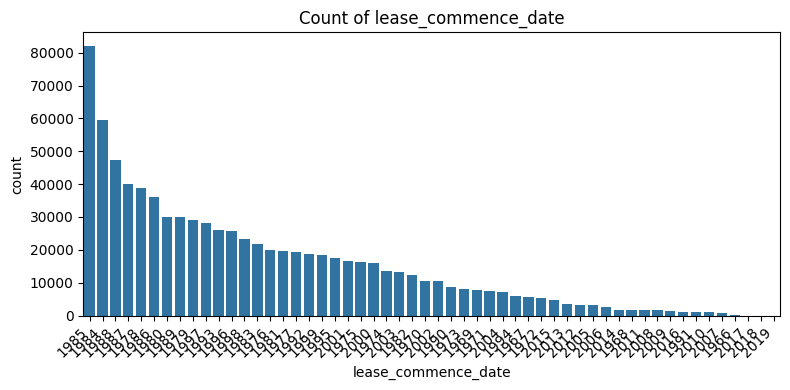

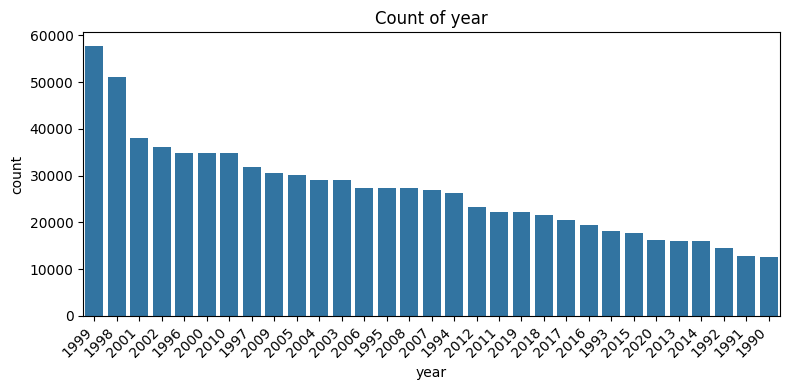

In [44]:
cat_cols = ['town', 'flat_type', 'storey_range','flat_model','lease_commence_date','year']

for col in cat_cols:
    plt.figure(figsize=(8, 4))

    sns.countplot(
        data=df,
        x=col,
        order=df[col].value_counts().index
    )

    plt.title(f'Count of {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Price per sqm vs remaining_lease_years and floor_area_sqm

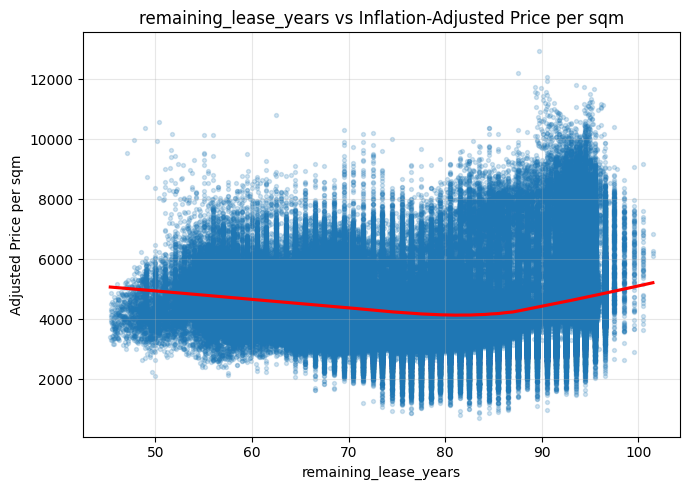

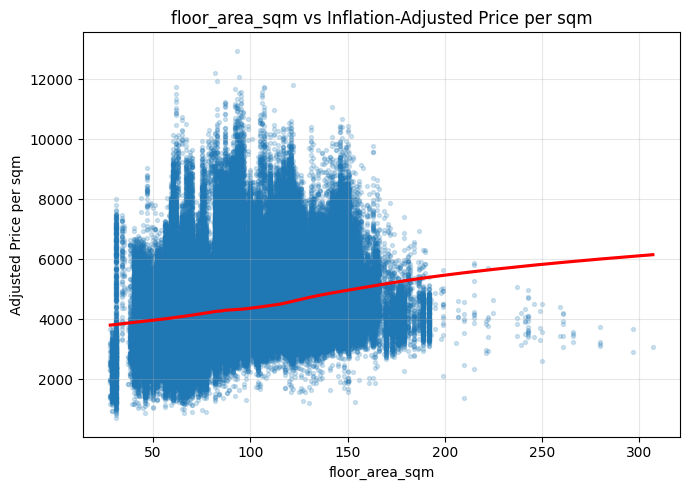

In [45]:

target = "adjusted_price_psm"

check_cols = ['remaining_lease_years','floor_area_sqm']
for col in check_cols:
    plt.figure(figsize=(7, 5))

    sns.regplot(
        data=df,
        x=col,
        y=target,
        scatter_kws={"alpha": 0.2, "s": 8},
        line_kws={"color": "red"},
        lowess=True   # smoother, safer for non-linear relationships
    )

    plt.title(f"{col} vs Inflation-Adjusted Price per sqm")
    plt.xlabel(col)
    plt.ylabel("Adjusted Price per sqm")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Remaining lease years: Prices per sqm dip slightly for mid-lease flats and rise again for very long remaining leases, reflecting a premium for newer or recently renewed flats.

Floor area: Larger flats tend to have higher prices per sqm on average, but with substantial dispersion, showing that size alone does not determine value.

### check HDB size over time

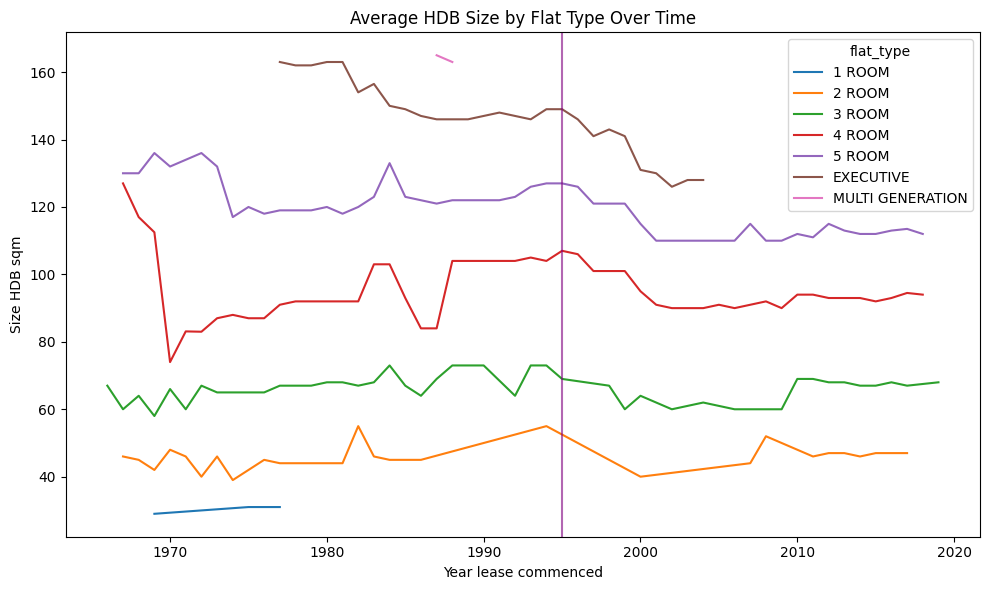

In [ ]:
plot_df = (
    df.groupby(['lease_commence_date', 'flat_type'])['floor_area_sqm']
      .median()
      .reset_index()
)


plt.figure(figsize=(10,6))

sns.lineplot(
    data=plot_df,
    x='lease_commence_date',
    y='floor_area_sqm',
    hue='flat_type',
    hue_order=['1 ROOM','2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM','EXECUTIVE','MULTI GENERATION']
)

plt.axvline(1995, color='purple', alpha=0.6)


plt.xlabel('Year lease commenced')
plt.ylabel('Size HDB sqm')
plt.title('Average HDB Size by Flat Type Over Time')
plt.tight_layout()
plt.show()
#Response A highlights that although flat sizes have been shrinking from the 1995 high, they have stabilised since 2000, and suggests the public message can emphasise that part instead. Telling the public that flat sizes have stabilised for nearly two decades now is factually accurate, after all.

Older HDB flats were generally built larger, especially for bigger flat types like executive and 5-room units.
Over time, average flat sizes declined and then stabilised, reflecting changes in housing policy and land constraints.
Smaller flat types show less variation, while larger flats experienced the biggest reductions in size.

### Check number of differnt types of flats over the years

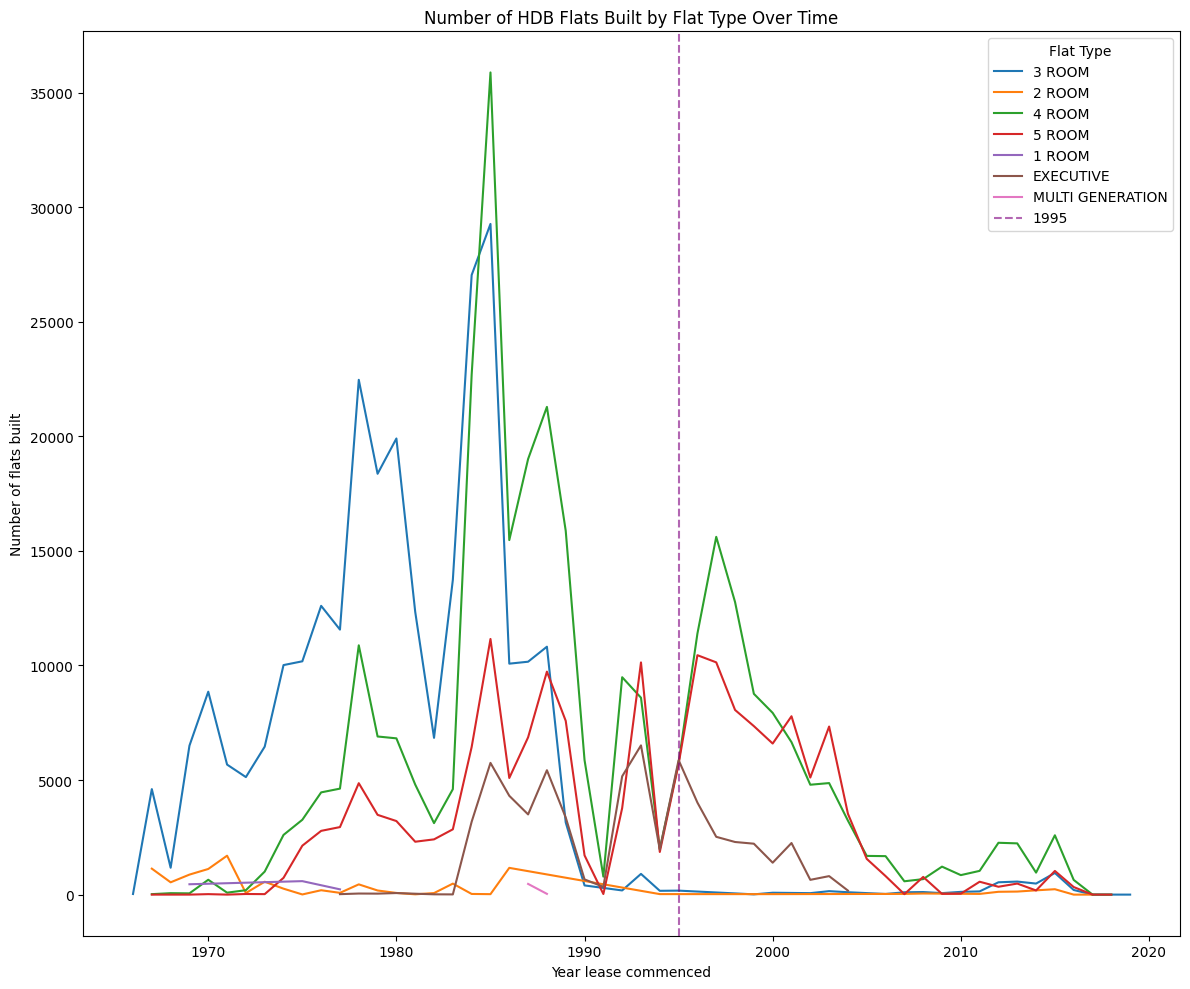

In [ ]:
plot_df = (
    df
    .groupby(['lease_commence_date', 'flat_type'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(12, 10))

sns.lineplot(
    data=plot_df,
    x='lease_commence_date',
    y='count',
    hue='flat_type'
)

plt.axvline(1995, color='purple', linestyle='--', alpha=0.6, label='1995')

plt.xlabel('Year lease commenced')
plt.ylabel('Number of flats built')
plt.title('Number of HDB Flats Built by Flat Type Over Time')

plt.legend(title='Flat Type')
plt.tight_layout()
plt.show()


HDB construction peaked in the late 1970s to late 1980s, driven mainly by large numbers of 3-room and 4-room flats.
After the mid-1990s, overall flat construction declined sharply, with a shift toward fewer and more targeted flat types.
Larger flats such as executive and multi-generation units were built mainly during earlier periods and became much rarer in later years.

### check median flat size over the years

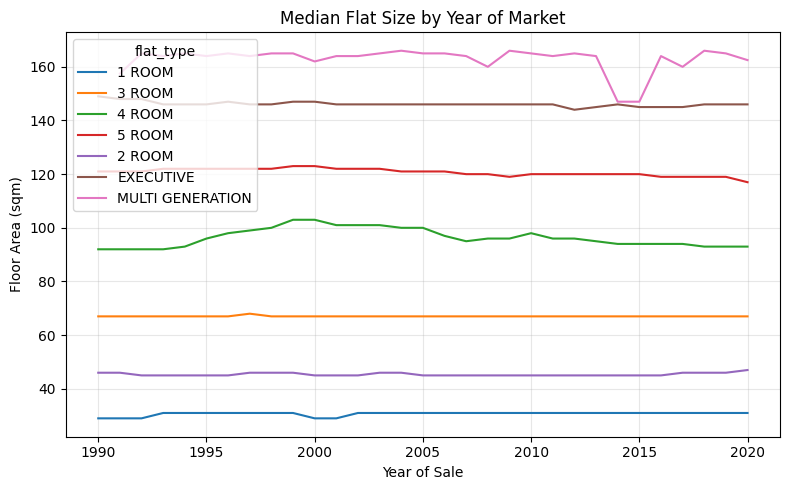

In [50]:
plt.figure(figsize=(8,5))

sns.lineplot(
    data=df,
    x="year",
    y="floor_area_sqm",
    hue="flat_type",
    estimator="median",
    errorbar=None
)

plt.title("Median Flat Size by Year of Market")
plt.xlabel("Year of Sale")
plt.ylabel("Floor Area (sqm)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Flat sizes have not changed much when viewed by year of construction, but they appear to decline when viewed by year of sale.
This happens because older, larger flats were more common in earlier resale transactions, but gradually became less available as owners held on to them.
As a result, newer and slightly smaller flats now make up a larger share of resale sales, meaning buyers increasingly see smaller units on the market and this trend is likely to continue.

### Town vs flat_type composition (stacked proportions)

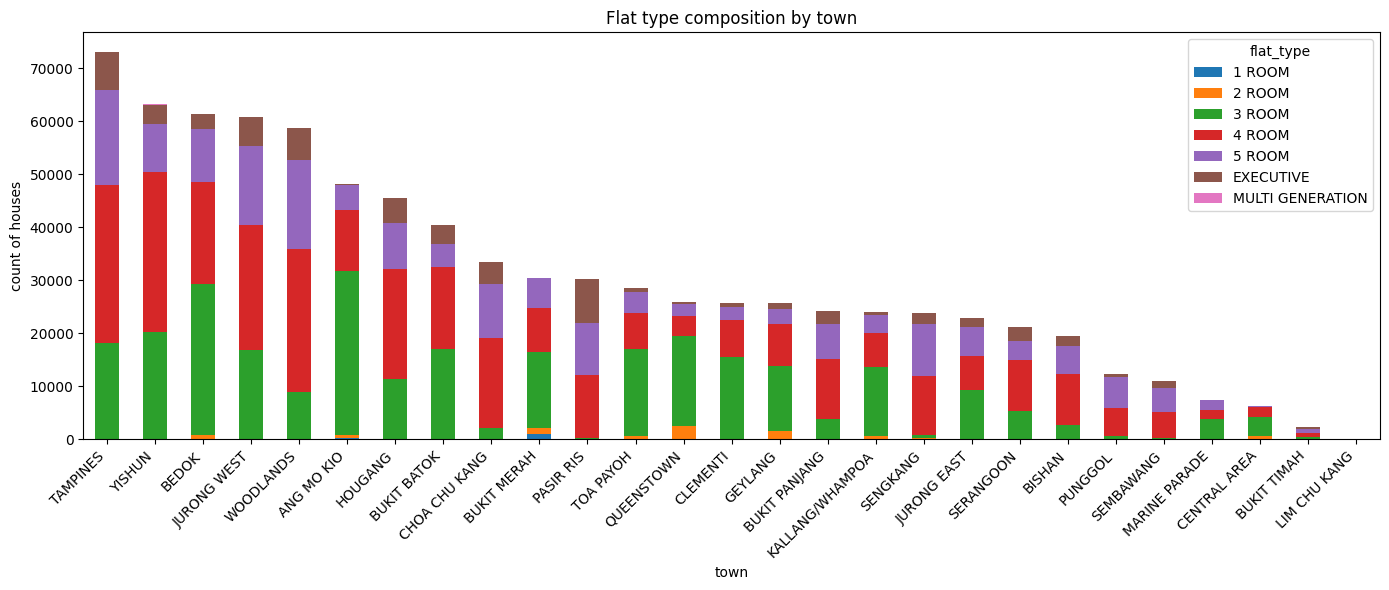

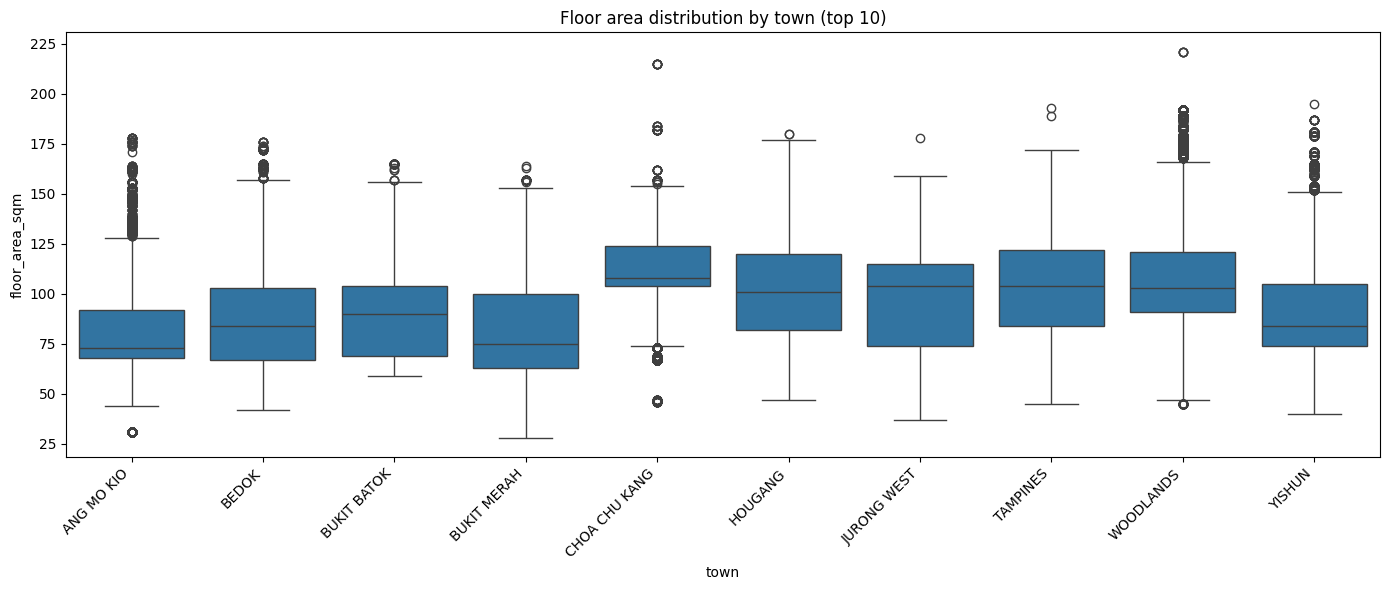

In [ ]:

ct = pd.crosstab(df["town"], df["flat_type"])
ct = ct.loc[df["town"].value_counts().head(30).index]  # top 15 towns


ct.plot(kind="bar", stacked=True, figsize=(14,6))
plt.title("Flat type composition by town")
plt.ylabel("count of houses")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



# Size distribution by town (boxplot)
top_towns = df["town"].value_counts().head(10).index
plt.figure(figsize=(14,6))
sns.boxplot(data=df[df["town"].isin(top_towns)], x="town", y="floor_area_sqm")
plt.xticks(rotation=45, ha="right")
plt.title("Floor area distribution by town (top 10)")
plt.tight_layout()
plt.show()


Different towns have very different flat-type mixes, with larger towns like Tampines, Yishun, and Bedok dominated by 3- and 4-room flats, while central or mature towns have fewer units overall.
Outer towns such as Woodlands, Jurong West, and Choa Chu Kang tend to offer larger average flat sizes, reflecting family-oriented housing supply.
More central and mature estates show smaller median floor areas and less variation, highlighting space constraints and older housing stock.

### Floor area vs adjusted price per sqm

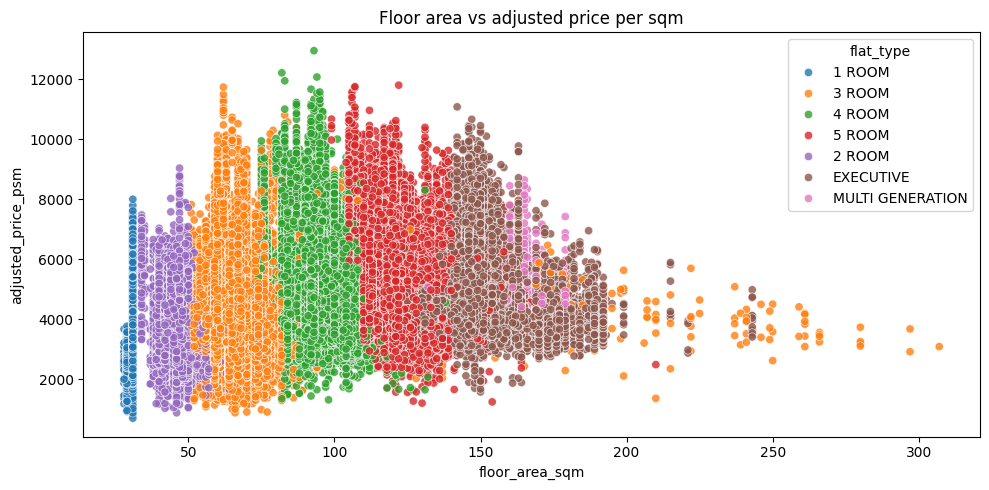

In [52]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x="floor_area_sqm", y=target, hue="flat_type", alpha=0.8)
plt.title("Floor area vs adjusted price per sqm")
plt.tight_layout()
plt.show()

Adjusted price per sqm varies widely across floor areas, with clear clustering by flat type rather than a simple linear relationship with size.
A small number of very large flats show extreme values, but these appear to be valid observations rather than data errors, reflecting premium or atypical units.

### Price variation within same flat_type among different flat_models


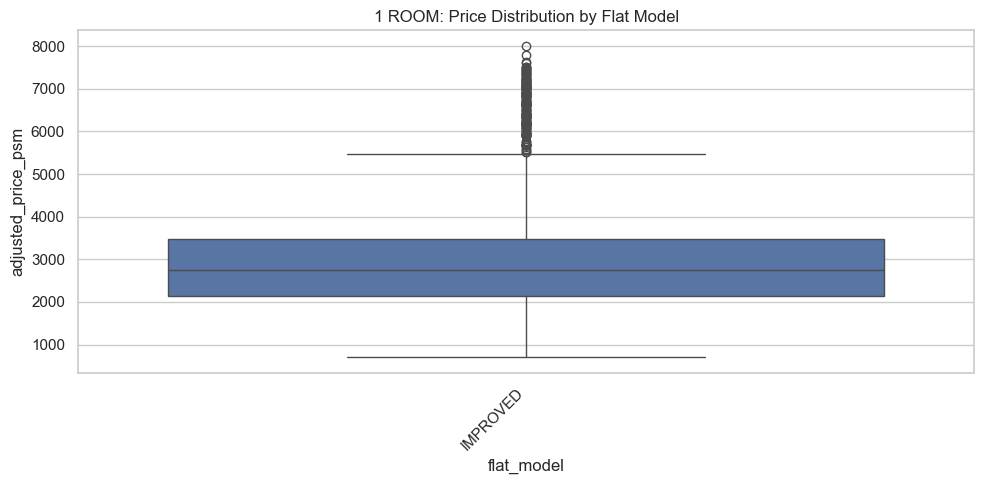

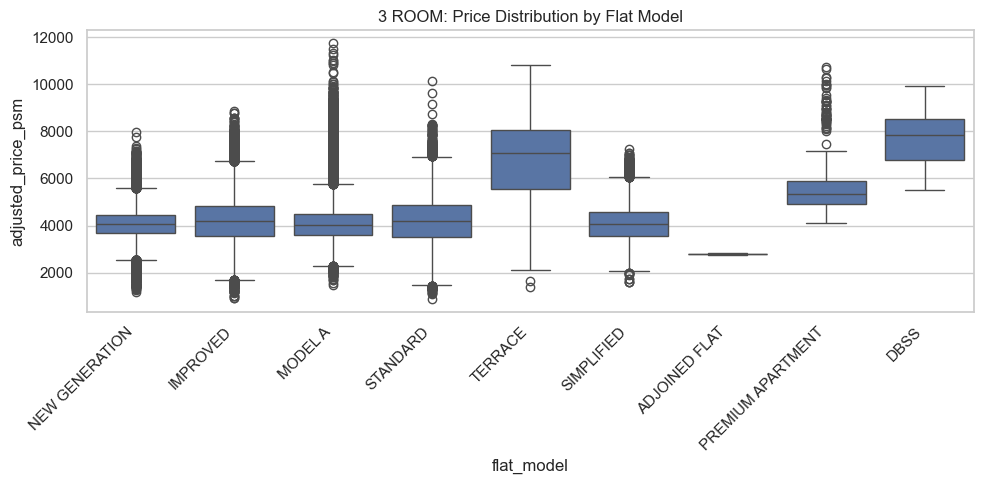

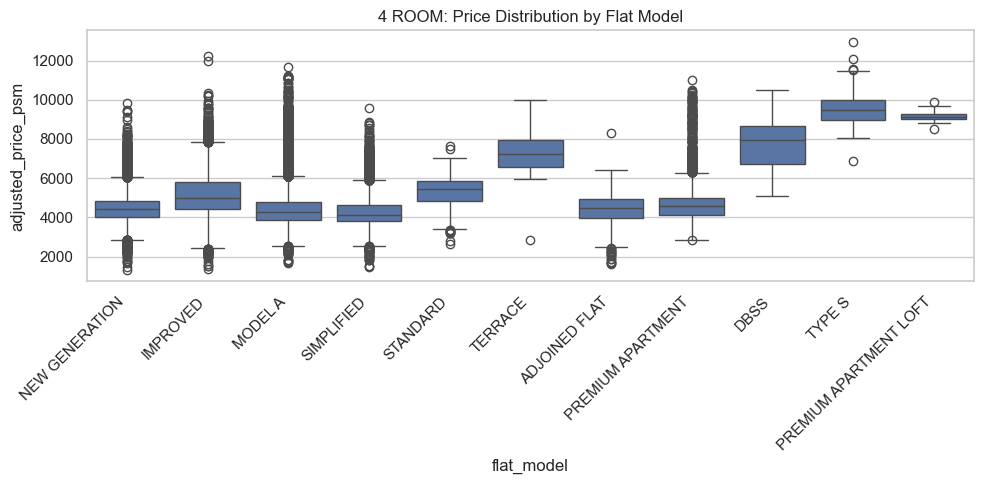

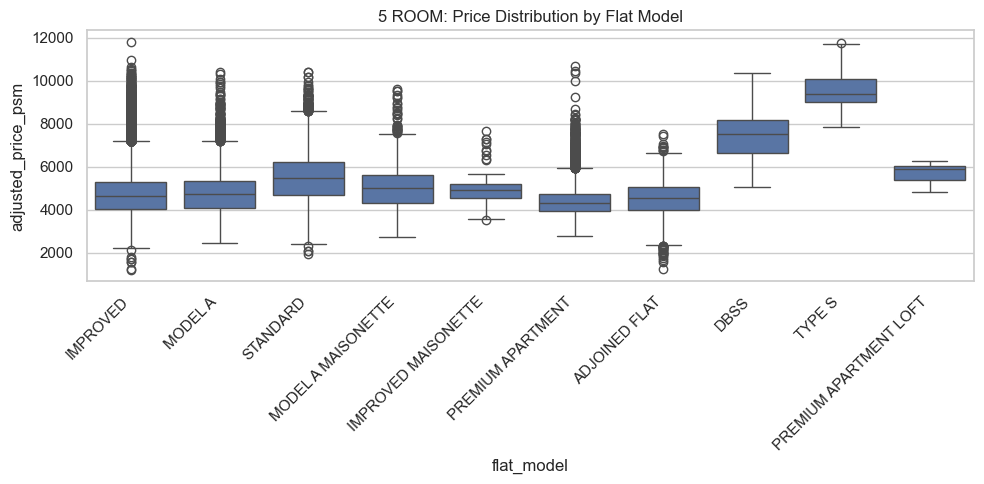

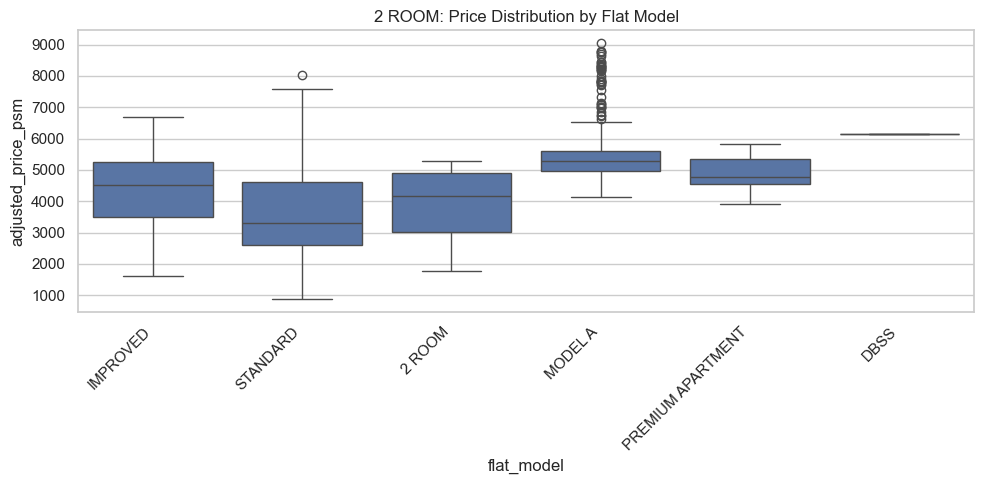

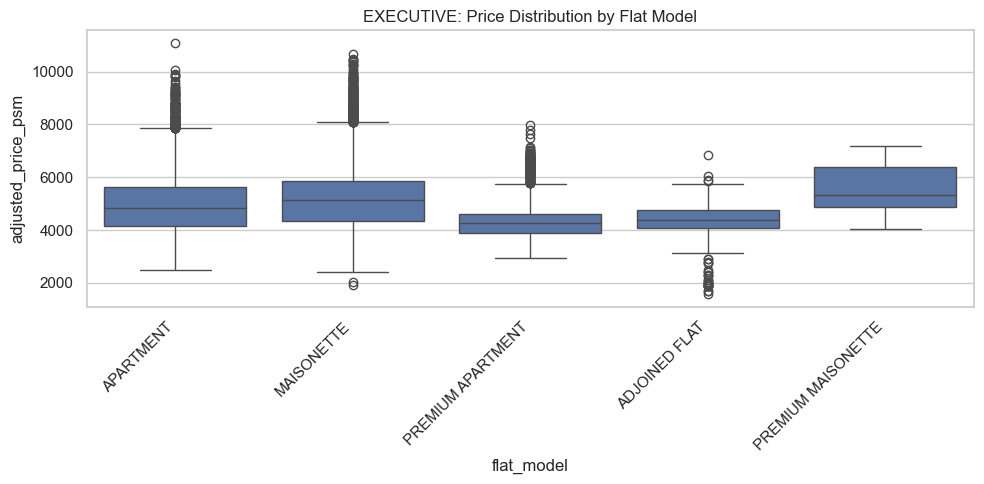

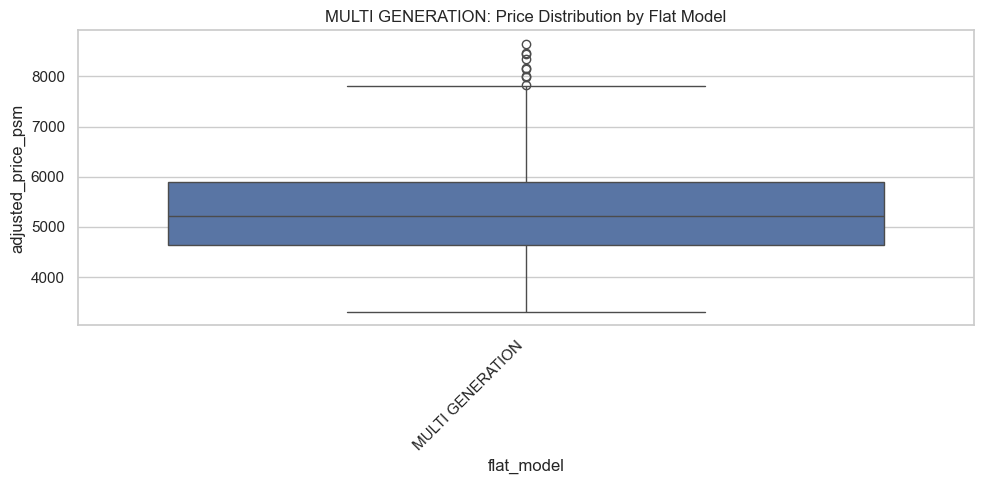

In [ ]:

sns.set(style="whitegrid")

for ft in df['flat_type'].unique():
    sub = df[df['flat_type'] == ft]

    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=sub,
        x='flat_model',
        y='adjusted_price_psm'
    )
    plt.title(f'{ft}: Price Distribution by Flat Model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

I first analysed price distributions across flat models within each flat type.
Boxplots and median price comparisons show that certain rare models exhibit
similar pricing behaviour to their parent categories, while premium and maisonette variants consistently command higher prices.

3-room flats behave almost the same across models (Improved, Model A, New Generation, Simplified, Standard).

4-room 5-room flats DBSS, TYPES and Premium Apartment is higher than the rest.

Executive flats (Apartment, Maisonette, Premium) overlap strongly in prices, with Maisonettes showing slightly more variation due to size.

In [56]:
df.to_csv("data/df_full.csv",index=False)

In [57]:
df = pd.read_csv("data/df_full.csv")
df.columns

Index(['town', 'flat_type', 'block', 'street_name', 'storey_range',
       'storey_mid', 'flat_model', 'lease_commence_date', 'year',
       'remaining_lease_years', 'adjusted_price_psm', 'full_address',
       'hdb_LATITUDE', 'hdb_LONGITUDE', 'hdb_POSTAL', 'nearest_mrt_dist_km',
       'nearest_primary_dist_km', 'dist_to_city_centre_km', 'floor_area_sqm'],
      dtype='object')

In [58]:

df = df[['year','adjusted_price_psm','town', 'flat_type', 'storey_mid', 'flat_model', 'floor_area_sqm',
       'remaining_lease_years', 'nearest_mrt_dist_km',
       'nearest_primary_dist_km', 'dist_to_city_centre_km']]

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826581 entries, 0 to 826580
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   year                     826581 non-null  int64  
 1   adjusted_price_psm       826581 non-null  float64
 2   town                     826581 non-null  object 
 3   flat_type                826581 non-null  object 
 4   storey_mid               826581 non-null  int64  
 5   flat_model               826581 non-null  object 
 6   floor_area_sqm           826581 non-null  float64
 7   remaining_lease_years    826581 non-null  float64
 8   nearest_mrt_dist_km      816010 non-null  float64
 9   nearest_primary_dist_km  816010 non-null  float64
 10  dist_to_city_centre_km   816010 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 69.4+ MB


In [60]:
df

,year,adjusted_price_psm,town,flat_type,storey_mid,flat_model,floor_area_sqm,remaining_lease_years,nearest_mrt_dist_km,nearest_primary_dist_km,dist_to_city_centre_km
0,1990,1599.761051,ANG MO KIO,1 ROOM,11,IMPROVED,31.0,86.500000,1.251742,0.397193,10.495038
1,1990,1066.507368,ANG MO KIO,1 ROOM,5,IMPROVED,31.0,86.500000,1.251742,0.397193,10.495038
2,1990,1422.009823,ANG MO KIO,1 ROOM,11,IMPROVED,31.0,86.500000,1.251742,0.397193,10.495038
3,1990,1066.507368,ANG MO KIO,1 ROOM,8,IMPROVED,31.0,86.500000,1.251742,0.397193,10.495038
4,1990,3562.816393,ANG MO KIO,3 ROOM,5,NEW GENERATION,73.0,85.500000,0.986904,0.405152,9.192749
...,...,...,...,...,...,...,...,...,...,...,...
826576,2020,3358.778626,YISHUN,5 ROOM,8,IMPROVED,131.0,66.250000,0.887593,0.344245,16.018368
826577,2020,3754.098361,YISHUN,5 ROOM,8,IMPROVED,122.0,65.500000,0.478352,0.331144,15.889989
826578,2020,4016.393443,YISHUN,5 ROOM,5,IMPROVED,122.0,66.333333,0.257345,0.445030,14.702325
826579,2020,3821.917808,YISHUN,EXECUTIVE,5,MAISONETTE,146.0,66.250000,0.354754,0.513539,15.296260


### Correlation heatmap

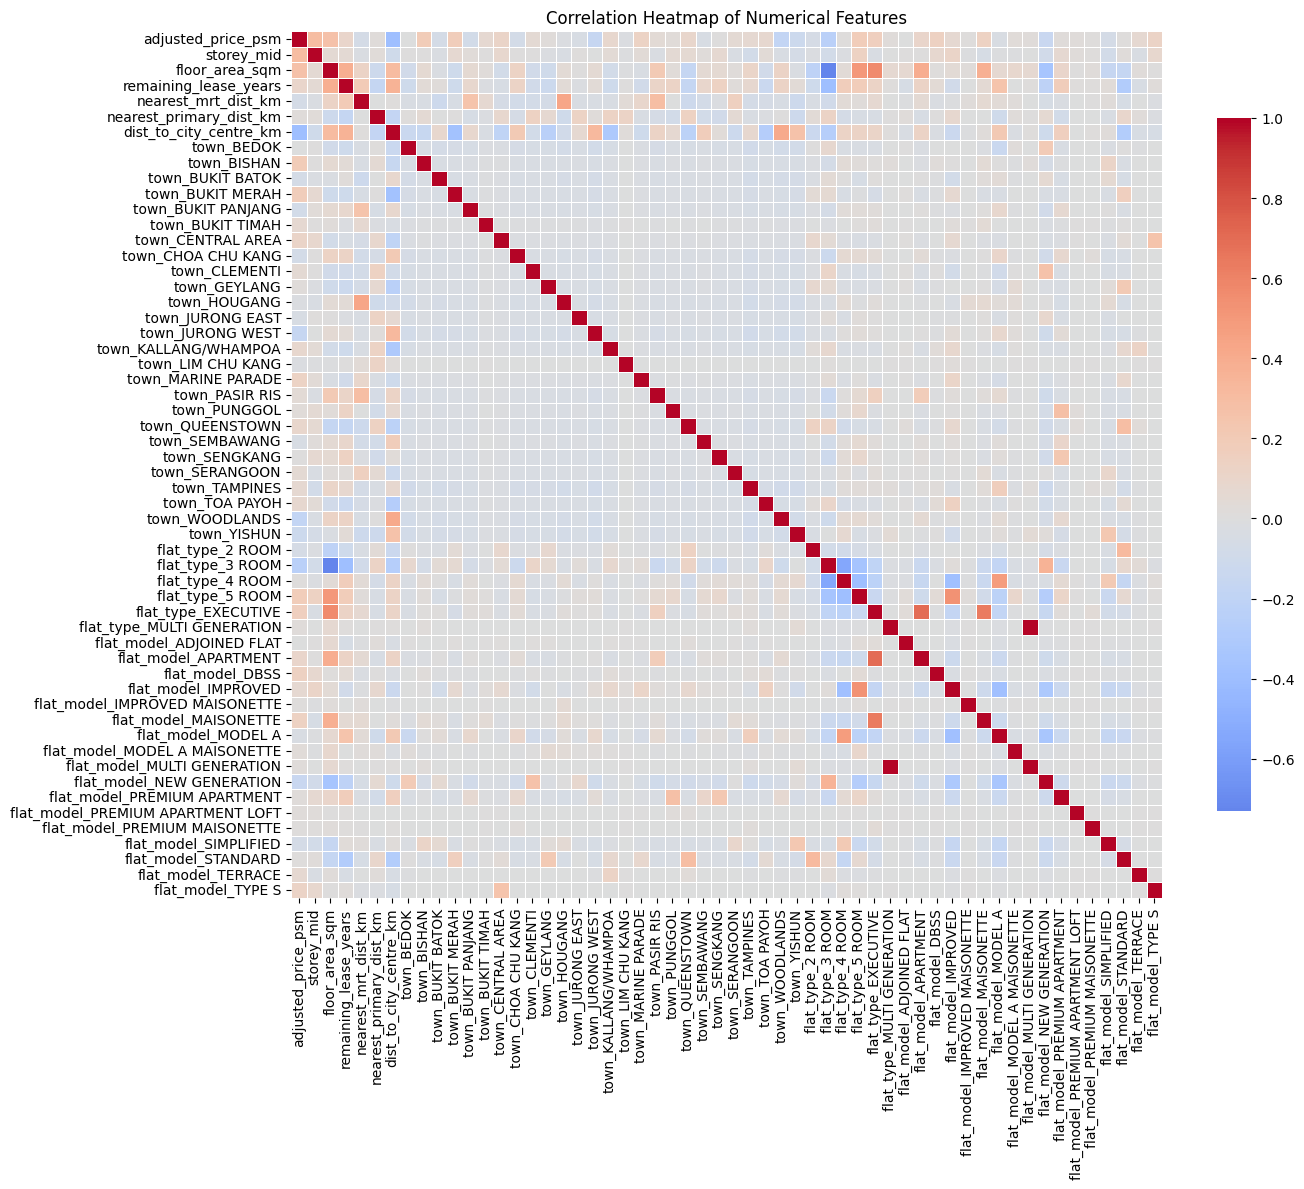

In [ ]:

#one hot the categorical features to plot the correlation
cat_cols = df.select_dtypes(include="object").columns.tolist()
num_df = df.select_dtypes(include="number")

cat_df = pd.get_dummies(df[cat_cols], drop_first=True)
corr_df = pd.concat([num_df, cat_df], axis=1)

corr_df = corr_df.drop(columns=["year"])
    
corr = corr_df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,      
    fmt=".2f",         
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

# Modeling

## Base model  Ridge model

In [ ]:
#### Use data before 2015 as train, 2015-2020 as test data

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("data/df_full.csv")
df.columns
df = df[['year','adjusted_price_psm','town', 'flat_type', 'storey_mid', 'flat_model', 'floor_area_sqm',
       'remaining_lease_years', 'nearest_mrt_dist_km',
       'nearest_primary_dist_km', 'dist_to_city_centre_km']]


df = df.copy()

num_features = [
    "floor_area_sqm",
    "storey_mid",
    "remaining_lease_years",
    "nearest_mrt_dist_km",
    "nearest_primary_dist_km",
    "dist_to_city_centre_km"
]

cat_features = ["town", "flat_type", "flat_model"]

train_df = df[df["year"] < 2015]
test_df  = df[(df["year"] >= 2015) & (df["year"] <= 2020)]

X_train = train_df[num_features + cat_features]
y_train = train_df["adjusted_price_psm"]

X_test  = test_df[num_features + cat_features]
y_test  = test_df["adjusted_price_psm"]

#Preprocessing + Ridge model
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

ridge_model = Ridge(alpha=10.0, random_state=42)

linear_pipeline = Pipeline(
    steps=[
        ("prep", preprocess),
        ("ridge", ridge_model)
    ]
)

linear_pipeline.fit(X_train, y_train)

#Evaluation
def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred)
    }
pred_train = linear_pipeline.predict(X_train)
pred_test  = linear_pipeline.predict(X_test)

metrics = pd.DataFrame([
    {"Split": "Train", **eval_metrics(y_train, pred_train)},
    {"Split": "Test",  **eval_metrics(y_test, pred_test)}
])

metrics

,Split,MAE,RMSE,R2
0,Train,501.087539,664.874828,0.489962
1,Test,667.955578,864.451576,0.460899


## Predicted vs Actual plot and coefficient

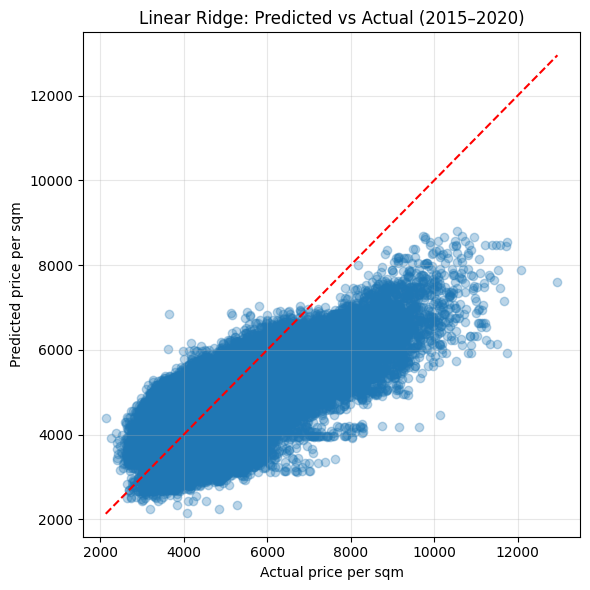

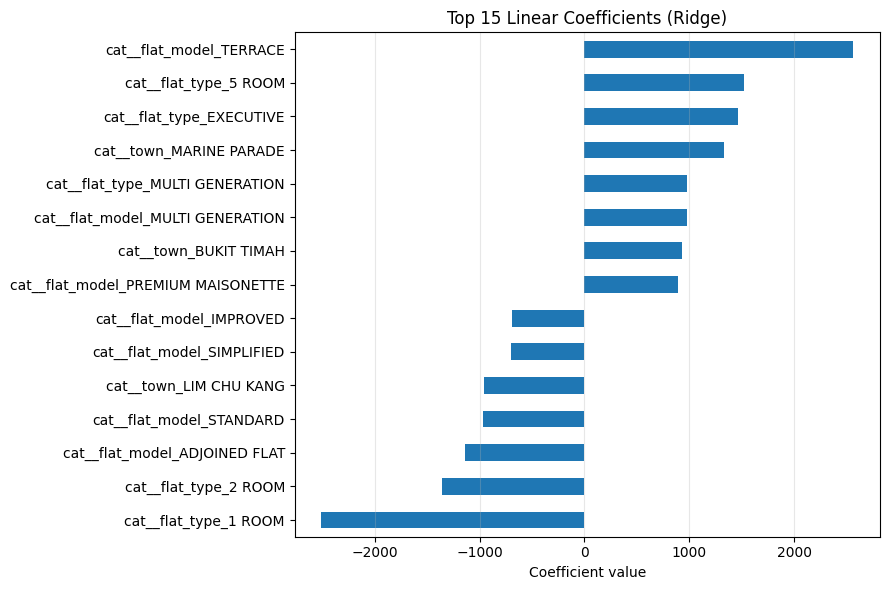

In [ ]:

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_test, alpha=0.3)

min_v = min(y_test.min(), pred_test.min())
max_v = max(y_test.max(), pred_test.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--")

plt.xlabel("Actual price per sqm")
plt.ylabel("Predicted price per sqm")
plt.title("Linear Ridge: Predicted vs Actual (2015–2020)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#Linear feature importance (coefficients)

feature_names = linear_pipeline.named_steps["prep"].get_feature_names_out()
coefs = linear_pipeline.named_steps["ridge"].coef_

coef_df = (
    pd.Series(coefs, index=feature_names)
    .sort_values(key=np.abs, ascending=False)
)

coef_df.head(15)
#Plot top 15 coefficients

coef_df.head(15).sort_values().plot(
    kind="barh",
    figsize=(9,6)
)
plt.title("Top 15 Linear Coefficients (Ridge)")
plt.xlabel("Coefficient value")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## Xgb + TimeSeriesSplit + RandomSearch

#### Without Hyperparameter tuning


In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
df = pd.read_csv("data/df_full.csv")
df.columns
df = df[['year','adjusted_price_psm','town', 'flat_type', 'storey_mid', 'flat_model', 'floor_area_sqm',
       'remaining_lease_years', 'nearest_mrt_dist_km',
       'nearest_primary_dist_km', 'dist_to_city_centre_km']]


df = df.copy()

num_features = [
    "floor_area_sqm",
    "storey_mid",
    "remaining_lease_years",
    "nearest_mrt_dist_km",
    "nearest_primary_dist_km",
    "dist_to_city_centre_km"
]

cat_features = ["town", "flat_type", "flat_model"]

train_df = df[df["year"] < 2015]
test_df  = df[(df["year"] >= 2015) & (df["year"] <= 2020)]

X_train = train_df[num_features + cat_features]
y_train = train_df["adjusted_price_psm"]

X_test  = test_df[num_features + cat_features]
y_test  = test_df["adjusted_price_psm"]
#preprocessing

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# model
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2000,          # big, rely on early stopping
    learning_rate=0.03,         # smaller lr
    max_depth=5,                # smaller tree
    min_child_weight=10,        # stronger constraint
    gamma=1.0,                  # discourage splits
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1
)



pipeline = Pipeline(
    steps=[
        ("prep", preprocess),
        ("xgb", xgb)
    ]
)

param_dist = {
    "xgb__n_estimators": [100, 200, 300],
    "xgb__learning_rate": [0.02, 0.03, 0.05],

    "xgb__max_depth": [3, 4, 5, 6],
    "xgb__min_child_weight": [5, 10, 20],
    "xgb__gamma": [0, 0.5, 1, 2],

    "xgb__subsample": [0.6, 0.7, 0.8],
    "xgb__colsample_bytree": [0.6, 0.7, 0.8],

    "xgb__reg_alpha": [0, 0.01, 0.1, 1.0],
    "xgb__reg_lambda": [1, 2, 5, 10],
}


param_dist = {
    "xgb__n_estimators": [100],
    #"xgb__max_depth": [6, 8, 10],
    #"xgb__learning_rate": [0.03, 0.05, 0.1],
    #"xgb__subsample": [0.7, 0.9],
    #"xgb__colsample_bytree": [0.7, 0.9]
}



tscv = TimeSeriesSplit(n_splits=3)

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=1,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)

best_model = rs.best_estimator_

def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred)
    }

pred_train = best_model.predict(X_train)
pred_test  = best_model.predict(X_test)

metrics = pd.DataFrame([
    {"Split": "Train", **eval_metrics(y_train, pred_train)},
    {"Split": "Test",  **eval_metrics(y_test, pred_test)}
])

metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


,Split,MAE,RMSE,R2
0,Train,408.089791,548.933360,0.652334
1,Test,566.954662,801.462343,0.536601


## Xgb hyperparameter tuning

In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

df = pd.read_csv("data/df_full.csv")
df.columns
df = df[['year','adjusted_price_psm','town', 'flat_type', 'storey_mid', 'flat_model', 'floor_area_sqm',
       'remaining_lease_years', 'nearest_mrt_dist_km',
       'nearest_primary_dist_km', 'dist_to_city_centre_km']]


df = df.copy()

num_features = [
    "floor_area_sqm",
    "storey_mid",
    "remaining_lease_years",
    "nearest_mrt_dist_km",
    "nearest_primary_dist_km",
    "dist_to_city_centre_km"
]

cat_features = ["town", "flat_type", "flat_model"]

train_df = df[df["year"] < 2015]
test_df  = df[(df["year"] >= 2015) & (df["year"] <= 2020)]

X_train = train_df[num_features + cat_features]
y_train = train_df["adjusted_price_psm"]

X_test  = test_df[num_features + cat_features]
y_test  = test_df["adjusted_price_psm"]
#preprocessing

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# model
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,         
    learning_rate=0.03,         
    max_depth=5,                
    min_child_weight=10,        
    gamma=1.0,                  
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1
)



pipeline = Pipeline(
    steps=[
        ("prep", preprocess),
        ("xgb", xgb)
    ]
)


param_dist = {
    "xgb__n_estimators": [100, 200, 300],
    "xgb__learning_rate": [0.02, 0.03, 0.05],

    "xgb__max_depth": [4, 6, 8, 10, 12],
    "xgb__min_child_weight": [5, 10, 20],
    "xgb__gamma": [0, 0.5, 1, 2],

    "xgb__subsample": [0.6, 0.7, 0.8],
    "xgb__colsample_bytree": [0.6, 0.7, 0.8],

    "xgb__reg_alpha": [0, 0.01, 0.1, 1.0],
    "xgb__reg_lambda": [1, 2, 5, 10],
}

tscv = TimeSeriesSplit(n_splits=3)

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)

best_model = rs.best_estimator_


def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)   
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred)
    }
pred_train = best_model.predict(X_train)
pred_test  = best_model.predict(X_test)

metrics = pd.DataFrame([
    {"Split": "Train", **eval_metrics(y_train, pred_train)},
    {"Split": "Test",  **eval_metrics(y_test, pred_test)}
])

metrics

Fitting 3 folds for each of 25 candidates, totalling 75 fits


,Split,MAE,RMSE,R2
0,Train,238.093819,338.604394,0.867716
1,Test,442.996683,634.728346,0.709354


In [ ]:
best_parameters = rs.best_params_
print(best_parameters)

{'xgb__subsample': 0.7, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 200, 'xgb__min_child_weight': 10, 'xgb__max_depth': 12, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.6}


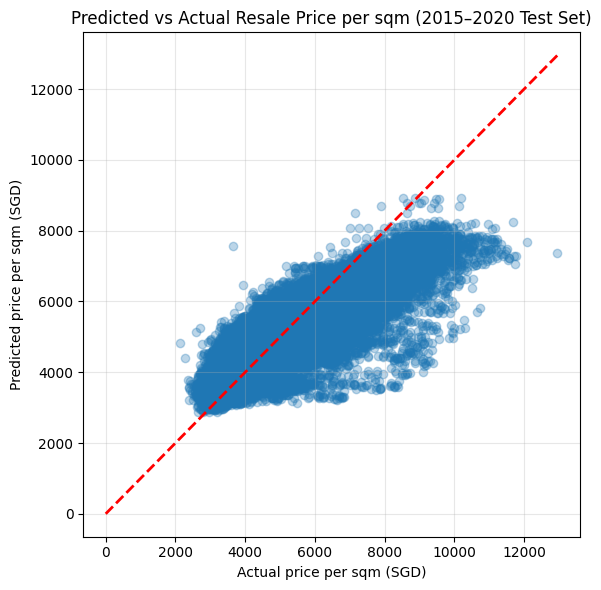

In [ ]:
# Predictions already in original price scale 
y_true = y_test
y_pred = pred_test

plt.figure(figsize=(6,6))

plt.scatter(
    y_true,
    y_pred,
    alpha=0.3
)

max_val = max(y_true.max(), y_pred.max())
plt.plot(
    [0, max_val],
    [0, max_val],
    "r--",
    linewidth=2
)

plt.xlabel("Actual price per sqm (SGD)")
plt.ylabel("Predicted price per sqm (SGD)")
plt.title("Predicted vs Actual Resale Price per sqm (2015–2020 Test Set)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Plotting the prediction and feature importances

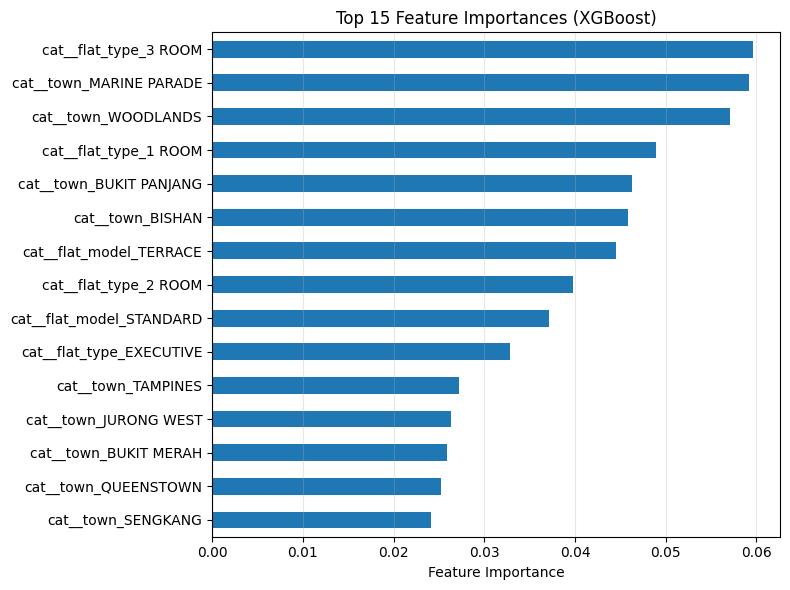

In [ ]:
# Get feature names after preprocessing
feature_names = (
    best_model.named_steps["prep"]
    .get_feature_names_out()
)

importances = pd.Series(
    best_model.named_steps["xgb"].feature_importances_,
    index=feature_names
).sort_values(ascending=False)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

importances.head(15).plot(
    kind="barh"
)

plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# Model Prediction Task I
### Objective

The objective is to build a predictive algorithm to identify key factors affecting residential property prices in Singapore, and to derive insights that can inform strategies for curbing housing price inflation. The model must be reproducible by colleagues on standard local machines without GPU access.

### Data Preparation and Feature Selection
Based on exploratory data analysis (EDA), the following groups of variables were found to be most relevant:

#### Structual attributes 
* Floor area (sqm)

* Flat type (e.g. 3-room, 4-room, Executive)

* Flat model (proxy for design era and layout)

* Storey level

* Remaining lease years

#### Location attributes

* Town 

* Distance to city centre

* Distance to nearest MRT station

* Distance to nearest primary school

* Price normalisation : Prices were inflation-adjusted and expressed as price per square metre to remove macro-inflation effects and isolate structural drivers.

These features were chosen because:

They are interpretable and policy-relevant.

They are available historically and can be maintained over time.

They capture both supply-side (flat design, size) and demand-side (location accessibility) factors.

### Modelling Approach and Justification
#### Model choice

Two models were used:

* Linear baseline model (Ridge Regression) – for interpretability and benchmarking.

* Tree-based model (XGBoost) – for capturing non-linear relationships and interactions.

XGBoost was selected as the primary model because:

* It performs well on tabular data.

* It runs efficiently on CPUs.

* It handles mixed numerical and categorical features effectively.

* It provides feature importance for interpretation.

#### Reproducibility

* A scikit-learn Pipeline was used to combine preprocessing and modelling.

* Missing values were handled using simple imputation (median for numeric, mode for categorical).

* Categorical variables were encoded using One-Hot Encoding.

* All random seeds were fixed to ensure reproducibility.

* No GPU-specific libraries were used.

* This ensures that colleagues can reproduce results on standard laptops.

#### Model Evaluation

A time-based split was used:

* Training data: transactions before 2015

* Test data: transactions from 2015–2020

This avoids data leakage and reflects real-world forecasting.

##### Performance (XGBoost)

Test MAE ≈ 440 SGD per sqm

Test R² ≈ 0.71

This indicates good predictive performance for a housing dataset with strong spatial heterogeneity.

#### Key Insights from the Model

###### Feature importance analysis shows:

* Town is the strongest driver of prices

* Location effects dominate all other variables.

* Even after controlling for flat size and type, large town-level price differences remain.

* Flat type and flat model are major contributors

* Larger and rarer flat types (e.g. Executive) command significant premiums.

* Certain flat models associated with older or premium designs retain higher value.

* Accessibility variables have secondary effects

* Distance to city centre, MRT, and schools do matter.

* However, once town is controlled for, their marginal impact is smaller.

* This suggests accessibility is largely capitalised into location itself.

#### Policy Implications and Strategies to Curb Price Inflation

Based on the findings, the following strategies can be considered:

##### Location-based supply intervention

* Since town-level effects dominate prices, increasing housing supply in high-demand towns (e.g. central or mature estates) can directly reduce upward price pressure.

##### Flat type mix management

* A higher proportion of large or premium flat types is associated with higher resale prices.

* Regulating the distribution of flat types in new developments can moderate price escalation.

##### Design standardisation

* Certain flat models command systematic premiums.

* Standardising layouts and limiting overly differentiated designs can reduce speculative pricing.

##### Targeted infrastructure planning

* New MRT lines do raise accessibility, but their price effects are uneven and already anticipated by the market.

* Infrastructure investments should be paired with concurrent housing supply to avoid capitalisation into prices.

# Model Prediction Task II

#### Considerations in Building an In-House Predictive Model

#### Building an in-house housing price model requires balancing accuracy, interpretability, scalability, and governance.

Key Considerations
#### 1. Interpretability vs. Complexity

Policy users require explanations, not just predictions.
Models must:

* Clearly explain why prices are high.

* Allow attribution to factors such as location, flat type, and lease.

This is why:

* Tree-based models with feature importance are preferred over black-box deep learning.

* Simple baselines are maintained alongside more complex models.

#### 2. Data Governance and Maintenance

An in-house model must rely on:

* Stable data sources (HDB transactions, MRT locations, school locations).

* Features that can be consistently updated.

* Highly manual or externally dependent data (e.g. speculative sentiment indicators) should be avoided.

#### 3. Temporal Robustness

* Housing markets evolve over time due to:

* Policy changes

* Infrastructure rollouts

* Demographic shifts

Therefore:

* Time-based validation is essential.

* Models should be retrained periodically.

* Feature drift should be monitored.

#### 4. Computational Constraints

* Since users do not have GPU access:

* CPU-efficient algorithms are required.

* Training time must be reasonable.

* Pipelines must run end-to-end on standard machines.

This justifies the use of:

* Scikit-learn pipelines

* Gradient boosting on CPU

* Avoidance of deep neural networks

#### 5. Responsible Use in Policy Context

Predictions should not be used in isolation.
They should support:

* Scenario analysis

* Policy stress testing

* Communication with the public

Importantly:

* Models should inform policy, not replace judgement.

#### Conclusion

* An effective in-house predictive model for housing prices should prioritise:

* Strong baseline performance

* Transparency

* Reproducibility

* Policy relevance

The modelling approach described balances these needs and provides actionable insights into the structural drivers of housing price inflation in Singapore.